# **Projet python pour la data science / 2024-2025**

Rédigé par:
* ABE Kevin
* DEMGNE Lisa
* ZAIDAN Oscar

## **Introduction**

   Un accident de la route ou accident de la circulation est entendu comme une collision non voulue, non prévue et mal anticipée d'au moins un engin roulant avec une chose, un animal ou une personne sur une voie publique ou privée ouverte à la circulation.Ils constituent un véritable fléau mondial, causant chaque année des milliers de morts et de blessés. Ces tragédies bouleversent des vies et ont un impact considérable sur la société. En France, la lutte contre ce phénomène est prise en charge au niveau national par la délégation à la sécurité routière, qui se sert des éclairages fourni par un document d'information édité annuellement par l'ONISR (Observatoire National Interministériel de la Sécurité Routière) faisant la synthèse des principales données de l'accidentologie.

Nous nous intéresserons dans le cadre de ce projet à la description de l'accidentologie en France en 2023, ainsi qu'a la prédiction du niveau de gravité d'un accident. Ainsi, ce projet se donne de renseigner sur la fréquence des accidents, le profil des victimes, les caractéristiques des véhicules impliqués, les conditions météorologiques,... et ainsi que les facteurs succeptibles d'influencer le niveau de gravité d'un accident.

In [61]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [62]:
# installation des packages qui pourrait ne pas être installer au préalable
!pip install requests
!pip install os
!pip install matplotlib
!pip install pandas 
!pip install plotly
!pip install plotly
!pip install io
!pip install seaborn
!pip install xlrd
!pip install ipywidgets
!pip install tabulate
!pip install ipywidgets 
!pip install tabulate 
!pip install scipy
!pip install numpy 
!pip install folium
!pip install IPython
!pip install geopandas
!pip install scikit-learn

ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
ERROR: Could not find a version that satisfies the requirement io (from versions: none)
ERROR: No matching distribution found for io


### Importation des Packages

In [63]:
import requests
import os
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import plotly
import plotly.express as px
import io
import seaborn as sns
import ipywidgets as widgets
from tabulate import tabulate
from scipy.stats import chi2_contingency
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import matplotlib.colors as mcolors

## **I- Importation des bases de données**

Dans cette partie, nous allons importer les bases données qui seront utilisées dans ce projet.
- base des usagers ayant été impliqué dans un accident de circulation en 2023
- base des véhicules impliqués dans les accidents de circulation en 2023
- base des lieux où se sont produit les accidents
- base contenant les caractéristiques des accidents.
- base des données démographiques de l'INSEE.




### 1- Importation des données sur les accidents de la circulation routière

In [64]:
# fonction de téléchargement des données sur les accidents corporels
def telecharge(url_data,filename, path):
    # Vérifie si le dossier 'data' existe, sinon le crée
    if not os.path.exists(path):
        os.makedirs(path)
    #télécharge les données avec l'url
    response = requests.get(url_data)
    if response.status_code == 200:
        file_path = os.path.join(path, filename)
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Fichier {filename} téléchargé avec succès:{file_path}")
    else:
        print(f"Echec de téléchargement pour {filename}. Statut: {response.status_code}")

# API pour accéder à l'url de téléchargement
url_root="https://www.data.gouv.fr/api/1/datasets/53698f4ca3a729239d2036df/resources/"
urls={
    "usagers-2023.csv":"68848e2a-28dd-4efc-9d5f-d512f7dbe66f",
    "vehicules-2023.csv":"146a42f5-19f0-4b3e-a887-5cd8fbef057b",
    "lieux-2023.csv":"8bef19bf-a5e4-46b3-b5f9-a145da4686bc",
    "caract-2023.csv":"104dbb32-704f-4e99-a71e-43563cb604f2"
}
path='data'

for filename, resource_id in urls.items():
    url=url_root+resource_id
    response1=requests.get(url)
    if response1.status_code==200:
        data=response1.json()
        url_data=data['url']
    else:
        print("downloading failed")
    telecharge(url_data,filename,path)


Fichier usagers-2023.csv téléchargé avec succès:data/usagers-2023.csv
Fichier vehicules-2023.csv téléchargé avec succès:data/vehicules-2023.csv
Fichier lieux-2023.csv téléchargé avec succès:data/lieux-2023.csv
Fichier caract-2023.csv téléchargé avec succès:data/caract-2023.csv


In [65]:
# base des usagers 
df_usagers = pd.read_csv("data/usagers-2023.csv", sep = ';')
df_usagers2 = df_usagers.copy()
df_usagers.head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202300000001,203 851 184,155 680 557,A01,1,1,4,1,1978.0,5,2,0,-1,-1,-1,-1
1,202300000002,203 851 182,155 680 556,A01,1,1,1,2,1997.0,9,1,0,-1,-1,-1,-1
2,202300000002,203 851 183,155 680 556,A01,10,3,3,1,1997.0,9,0,-1,-1,2,3,1
3,202300000003,203 851 180,155 680 554,B01,1,1,3,1,1987.0,0,2,6,0,0,0,-1
4,202300000003,203 851 181,155 680 555,A01,1,1,1,2,1984.0,0,1,0,0,0,0,-1


In [66]:
# Base des véhicules 
df_vehicules = pd.read_csv("data/vehicules-2023.csv", sep = ';')
df_vehicules.head()  

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202300000001,155 680 557,A01,1,30,0,0,5,1,1,NaN
1,202300000002,155 680 556,A01,2,7,0,1,1,1,1,NaN
2,202300000003,155 680 554,B01,1,2,0,2,1,16,1,NaN
3,202300000003,155 680 555,A01,2,7,0,2,2,15,1,NaN
4,202300000004,155 680 551,B01,1,7,0,2,9,2,4,NaN


In [67]:
# Base des lieux 
df_lieux = pd.read_csv("data/lieux-2023.csv", sep = ';')
df_lieux.head(5)

/tmp/ipykernel_17649/483356611.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_lieux = pd.read_csv("data/lieux-2023.csv", sep = ';')


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202300000001,4,RUE DE RIVOLI,0,NaN,1,2,0,1,-1,-1,1,NaN,-1,2,0,1,30
1,202300000001,4,RUE SAINT FLORENTIN,0,NaN,1,1,0,1,-1,-1,1,NaN,-1,2,0,1,30
2,202300000002,3,120,0,NaN,2,3,2,1,-1,-1,1,NaN,-1,2,0,1,50
3,202300000003,3,5,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50
4,202300000003,3,87,0,NaN,2,4,0,1,1,0,1,NaN,-1,2,5,1,50


In [68]:
# Base caract
df_caract = pd.read_csv("data/caract-2023.csv", sep = ';')
df_caract2 =df_caract.copy()
df_caract.head()

,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202300000001,7,5,2023,06:00,1,75,75101,2,4,2,7,RUE DE RIVOLI,"48,86638600","2,32347100"
1,202300000002,7,5,2023,05:30,5,94,94080,2,1,3,6,Avenue de Paris,"48,84547782","2,42868146"
2,202300000003,7,5,2023,20:50,1,94,94022,2,3,2,1,Avenue du Général Leclerc,"48,76240000","2,40655000"
3,202300000004,6,5,2023,23:57,5,94,94078,2,1,3,5,Rue de Paris,"48,73248432","2,44687575"
4,202300000005,7,5,2023,00:50,5,94,94068,2,2,3,3,56bis Avenue Raspail,"48,78581000","2,49217000"


Nous construisons à présent la base de données qui résultera de la fusion des toutes les bases importées précedemment.
Dans un premier temps, nous fusionnons la base des usagers et celle des véhicules sur les variables "Num_acc" (Numéro de l'accident), "id_vehicule" (identifiant du véhicule) et "num_veh" (numéro du véhicule) qui sont commun aux deux bases. Ensuite, nous fusionnons les autres bases sur la variable "Num_acc". Nous utilisons l'option "inner" qui utilise l'intersection des clés dans les deux tables.

In [69]:
# fusion des bases de données
df_merge = df_usagers.merge(df_vehicules, on=["Num_Acc","id_vehicule","num_veh"], how="inner") 
df_merge = df_merge.merge(df_lieux, on="Num_Acc", how="inner")
df_merge = df_merge.merge(df_caract, on="Num_Acc", how="inner")

### 2- Importation des données démographiques de l'INSEE

Dans cette section, nous récupérons le nombre d'habitants par département disponible sur le site de l'INSEE.

In [70]:
# URL du fichier XLS contenant les données de population par département
url = "https://www.insee.fr/fr/statistiques/fichier/7752095/estim-pop-dep-sexe-gca-1975-2024.xls"

# Chemin du dossier où enregistrer les fichiers
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)  # S'assure que le dossier "data" existe

try:
    # Télécharger le fichier XLS
    response = requests.get(url)
    response.raise_for_status()  # Vérifie que la requête a réussi

    # Chemin complet pour enregistrer le fichier XLS
    xls_file_path = os.path.join(output_dir, "estim-pop-dep-sexe-gca-1975-2024.xls")

    # Sauvegarder le fichier XLS localement
    with open(xls_file_path, "wb") as file:
        file.write(response.content)
    print(f"Fichier téléchargé et enregistré sous '{xls_file_path}'")

    # Charger les données dans un DataFrame pandas
    data = pd.read_excel(xls_file_path, sheet_name=None, engine='xlrd')  # Charger toutes les feuilles

    # Afficher les noms des feuilles pour choisir celle à traiter
    print("Feuilles disponibles :", data.keys())

    # Sélectionner une feuille spécifique (par exemple, la première)
    sheet_name = list(data.keys())[2]  # Adapte selon le nom exact de la feuille
    population_data = data[sheet_name]

    # Chemin complet pour enregistrer le fichier CSV
    csv_file_path = os.path.join(output_dir, "estim_pop_departement.csv")

    # Sauvegarder la feuille sélectionnée dans un fichier CSV local
    population_data.to_csv(csv_file_path, index=False, encoding="utf-8")
    print(f"Fichier '{csv_file_path}' enregistré avec succès !")

except ImportError as e:
    print("Erreur : xlrd n'est pas installé. Installez-le avec `pip install xlrd`.")
except requests.RequestException as e:
    print("Erreur lors du téléchargement des données :", e)
except Exception as e:
    print("Erreur lors du traitement des données :", e)


Fichier téléchargé et enregistré sous 'data/estim-pop-dep-sexe-gca-1975-2024.xls'
Feuilles disponibles : dict_keys(['À savoir', '2024', '2023', '2022', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010', '2009', '2008', '2007', '2006', '2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994', '1993', '1992', '1991', '1990', '1989', '1988', '1987', '1986', '1985', '1984', '1983', '1982', '1981', '1980', '1979', '1978', '1977', '1976', '1975'])
Fichier 'data/estim_pop_departement.csv' enregistré avec succès !


In [71]:
# Chemin du fichier local
file_path = 'data/estim-pop-dep-sexe-gca-1975-2024.xls'

try:
    # Charger la feuille 2023
    data_2023 = pd.read_excel(file_path, sheet_name='2023', engine='xlrd', header=None)

    # Extraire les colonnes pertinentes
    df_population = data_2023.iloc[5:101, [0, 7]]  # Lignes 6 à 101, colonnes 1 et 8

    # Renommer les colonnes pour plus de clarté
    df_population.columns = ['Département', 'Population']

    # Supprimer les lignes contenant des valeurs nulles, si nécessaire
    df_population.dropna(inplace=True)

    # Sauvegarder dans un fichier CSV
    df_population.to_csv("data/population_2023.csv", index=False, encoding='utf-8')
    print("Fichier 'population_2023.csv' créé avec succès.")

except Exception as e:
    print(f"Erreur lors du traitement du fichier : {e}")


Fichier 'population_2023.csv' créé avec succès.


In [72]:
df_population.head()

,Département,Population
5,01,674071
6,02,523308
7,03,333355
8,04,167334
9,05,141438


## **II- Analyses descriptives**

Dans cette partie, nous ferons essentiellement de l'analyse descriptive univariée et bivariée. De manière plus précise, il s'agira de visualiser la distribution des variables des différentes bases individuellement ou en croisant avec d'autres variables.

### 1)- Description de la base des usagers

Selon le "Guide BAAC 2017" un usager est une personne physique impliquée dans un accident de la circulation en tant que conducteur/passager d'un véhicule ou piéton.

La base usagers est constituée des variables d'identification des usagers, et principalement de variables catégorielles qui donnent des caractéristiques sur les usagers au moment de l'accident.

In [73]:
df_usagers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125789 entries, 0 to 125788
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      125789 non-null  int64  
 1   id_usager    125789 non-null  object 
 2   id_vehicule  125789 non-null  object 
 3   num_veh      125789 non-null  object 
 4   place        125789 non-null  int64  
 5   catu         125789 non-null  int64  
 6   grav         125789 non-null  int64  
 7   sexe         125789 non-null  int64  
 8   an_nais      123191 non-null  float64
 9   trajet       125789 non-null  int64  
 10  secu1        125789 non-null  int64  
 11  secu2        125789 non-null  int64  
 12  secu3        125789 non-null  int64  
 13  locp         125789 non-null  int64  
 14  actp         125789 non-null  object 
 15  etatp        125789 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 15.4+ MB


Par la suite, nous allons analyser les valeurs manquantes de cette base. Pour ce faire, en dehors des valeurs manquantes par défaut, nous remplaçons les modalités -1 par des valeurs manquantes, car en réalité ce sont des valeurs non renseignées donc des valeurs manquantes.

In [74]:
#recodage des variables trajet et actp de la base usager
df_usagers["trajet"]=df_usagers["trajet"].replace(0, value=-1)
df_usagers["actp"]=df_usagers["actp"].replace(0, value=-1)

for column in df_usagers.columns:
    df_usagers[column] = df_usagers[column].replace(-1, np.nan)
    df_usagers[column] = df_usagers[column].replace(' -1', np.nan)
    
missing_percentage = (df_usagers.isnull().sum() / len(df_usagers)) * 100
print("Pourcentage de valeurs manquantes par variable :")
print(missing_percentage)

Pourcentage de valeurs manquantes par variable :
Num_Acc         0.000000
id_usager       0.000000
id_vehicule     0.000000
num_veh         0.000000
place           0.001590
catu            0.000000
grav            0.093808
sexe            1.932601
an_nais         2.065363
trajet         28.461948
secu1           1.822099
secu2          44.057112
secu3          98.094428
locp           50.346215
actp           50.285001
etatp          91.971476
dtype: float64


Plusieurs variables contiennent des valeurs manquantes, et certaines n'apportent quasiment aucunes informations. Il s'agit des variables "secu3" (3e équipement de sécurité) et "etatp" (renseigne si le piéton était accompagné ou non). Nous allons donc les supprimer dans la suite. En outre, d'autres variables ont près de la moitié de leurs valeurs qui sont manquantes (localisation du piéton, action du piéton, deuxième équipement de sécurité), ce qui pourrait biaisé les analyses. Il seront à en tenir compte dans les analyses.

In [75]:
df_usagers=df_usagers.drop(["etatp","secu3"], axis=1)

Pour une meilleure visualisation des graphiques, nous allons affectés des labels aux modalités. 

In [76]:
#Mapping 
sexe_labels = {1: 'Masculin', 2: 'Féminin', -1: 'Autres'}
catu_labels = {1: 'Conducteur', 2: 'Passager', 3: 'Piéton'}
grav_labels = {1: 'Indemne', 2: 'Tué', 3: 'Blessé hospitalisé > 24h', 4: 'Blessé léger',-1: 'Non renseigné'}
secu1_labels = {-1: "Non renseigné", 0: "Aucun équipement", 1: "Ceinture", 2: "Casque", 3: "Dispositif enfants", 4: "Gilet réfléchissant",
                5: "Airbag (2RM/3RM)", 6: "Gants (2RM/3RM)", 7: "Gants + Airbag (2RM/3RM)", 8: "Non déterminable", 9: "Autre" }

secu2_labels = { -1: "Non renseigné", 0: "Aucun équipement", 1: "Ceinture", 2: "Casque", 3: "Dispositif enfants", 4: "Gilet réfléchissant",
                 5: "Airbag (2RM/3RM)", 6: "Gants (2RM/3RM)", 7: "Gants + Airbag (2RM/3RM)", 8: "Non déterminable", 9: "Autre" }

secu3_labels = {-1: "Non renseigné",0: "Aucun équipement",1: "Ceinture",2: "Casque",3: "Dispositif enfants",4: "Gilet réfléchissant",
                5: "Airbag (2RM/3RM)", 6: "Gants (2RM/3RM)", 7: "Gants + Airbag (2RM/3RM)", 8: "Non déterminable", 9: "Autre"}

locp_labels = { -1: 'Non renseigné', 0: 'Sans objet', 1: 'A + de 50 m du passage piéton', 2: 'A - de 50 m du passage piéton',
             3: 'Sans signalisation lumineuse', 4: 'Avec signalisation lumineuse', 5: 'Trottoir', 6: 'Sur accotement', 7: 'Sur refuge ou BAU',
            8: 'Sur contre-allée', 9: 'Inconnue' }                                                                                                                                  
actp_labels = { ' -1': 'Non renseigné', '0': 'Sans objet', '1': 'Sens du véhicule heurtant', '2': 'Sens inverse du véhicule heurtant',
              '3': 'Traversant', '4': 'Masqué', '5': 'Jouant-courant', '6': 'Avec animal', '7': 'Quitte l arrêt du TC', '8': 'Accède à l arrêt du TC',
              '9': 'Autre', 'A': 'Monte ou descend de son véhicule', 'B': 'Inconnu' }

etatp_labels = { -1:'Non renseigné', 0: 'Sans objet', 1: 'Seul', 2: 'Accompagé', 3: 'En groupe' }

trajet_labels = { -1:'Non renseigné', 0: 'Non renseigné', 1: 'Domicile-travail', 2: 'Domicile-école', 3: 'Courses-achats', 4: 'Utilisation professionnelle',
                 5: 'Promenade-loisirs', 9: 'Autre'}


In [77]:
def mapping_apply(data,mapping_dict):
    for column, mapping in mapping_dict.items():
        if column in data.columns: 
            data[column] = data[column].map(mapping)

In [78]:
mapping_dict1 = {
    "sexe": sexe_labels,
    "catu": catu_labels,
    "grav": grav_labels,
    "trajet": trajet_labels,
    "secu1": secu1_labels,
    "secu2": secu2_labels,
    "secu3": secu3_labels,
    "locp": locp_labels,
    "actp": actp_labels,
    "etatp": etatp_labels}
    
mapping_apply(df_usagers, mapping_dict1)

La fonction ci-dessous permet de représenter les distributions des variables catégorielles. Nous allons l'utiliser dans la suite pour faire les représentations graphiques. Elle prend en entrée le dataframe pandas contenant les données et la liste des colonnes à représenter.

In [79]:
def plot_all_distributions1(df, columns):

    # Définitions des titres des graphiques en fontion des variables choisies
    column_titles = {
        "catu":"Categorie d'usagers",
        "grav":"gravite des blessures de l'usager",
        "trajet":"Motif du deplacement au moment de l'accident",
        "secu1":"Equipement de securite 1",
        "secu2":"Equipement de securite 2",
        "secu3":"Equipement de securite 3",
        "locp":"Localisation du pieton",
        "actp":"Action du pieton",
        "etatp":"Etat du pieton",
        "senc": "Sens de circulation",
        "obs": "Obstacles fixes heurtés",
        "obsm": "Obstacle mobile heurté",
        "choc": "Point de choc initial",
        "manv": "Manœuvre principale avant l'accident",
        "motor": "Type de motorisation du véhicule",
        "place": "place"
    }
    
    # Définir le nombre de lignes et de colonnes pour les subplots
    n_cols = 2  # Nombre de colonnes par ligne pour agrandir les graphiques
    n_rows = (len(columns) + n_cols - 1) // n_cols  # Nombre total de lignes (arrondi vers le haut)
    
    # Initialiser la figure avec une taille plus grande
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6 * n_rows))
    axes = axes.flatten()  # Aplatir le tableau des axes pour un accès facile
    
    # Parcourir les colonnes pour créer chaque graphique
    for i, column in enumerate(columns):
        sns.countplot(data=df, x=column, palette='viridis', ax=axes[i])
        title = column_titles.get(column, column)  # Récupérer le titre ou le nom de la colonne par défaut
        axes[i].set_title(f"Distribution de '{title}'", fontsize=14)
        axes[i].set_xlabel(title, fontsize=12)
        axes[i].set_ylabel("Counts", fontsize=12)
        axes[i].tick_params(axis='x', rotation=60)
        
        # Ajouter les valeurs au-dessus des barres
        for p in axes[i].patches:
            axes[i].annotate(f'{int(p.get_height())}',
                             (p.get_x() + p.get_width() / 2., p.get_height()),
                             ha='center', va='center',
                             fontsize=10, color='black',
                             xytext=(0, 5), textcoords='offset points')
        
    # Supprimer les axes vides si le nombre de graphiques est inférieur aux subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

In [80]:
columns1 =["catu","grav","trajet","sexe"]
columns2 =["secu1","secu2","place","actp"]
columns3 =["locp"]

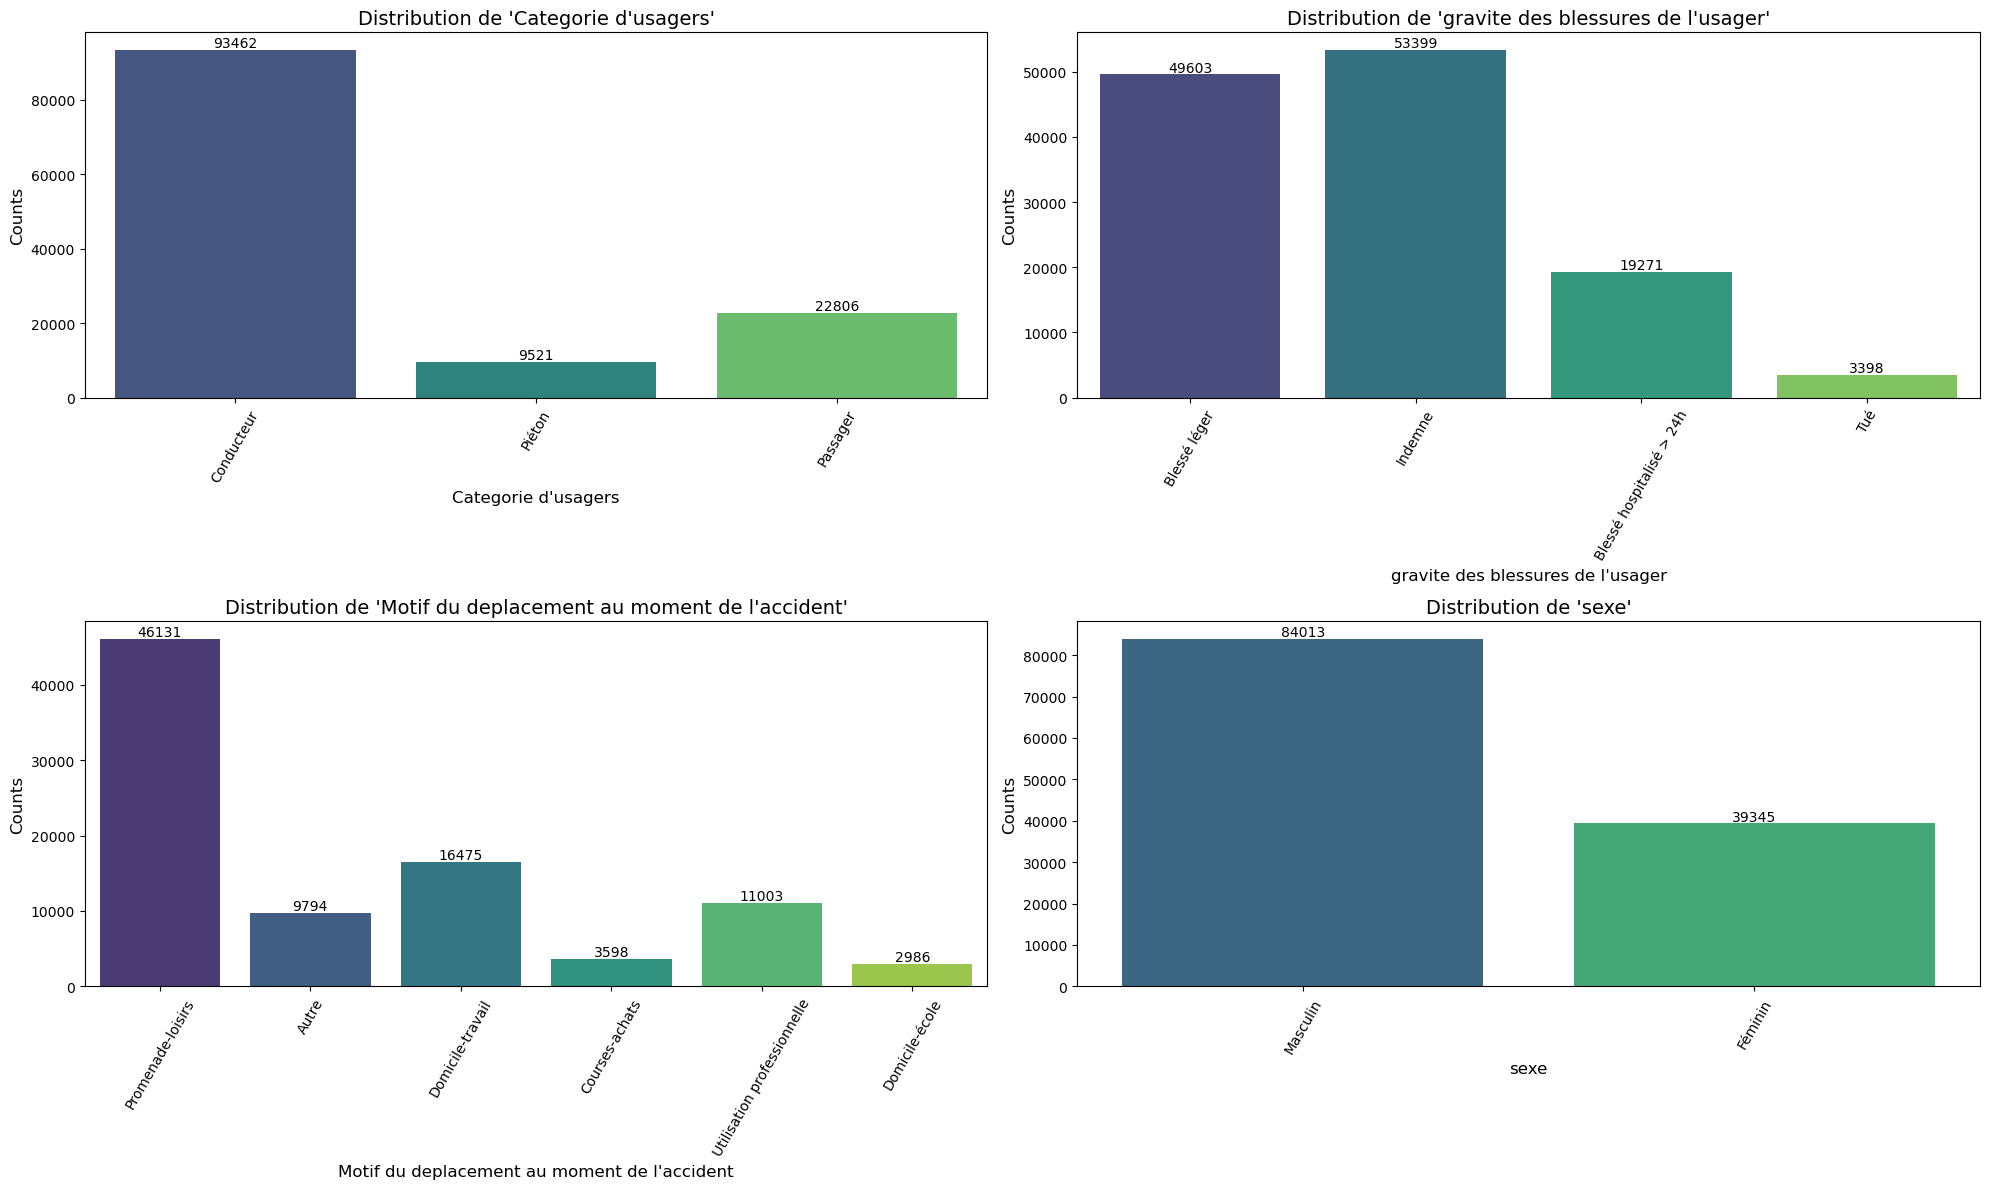

In [81]:
plot_all_distributions1(df_usagers, columns1)

On observe que la majorité des personnes impliquées dans des accidents sont des conducteurs (soit 93462 usagers), ensuite vient les passagers (22806 usagers) et enfin les piétons (9521 usagers).
Par la suite, il en ressort que la majorité des usagers s'en sont sortit indemnes après l'accident, suivie d'un nombre important d'usagers (49603) qui ont subit des blessures légères. Il en ressort également un résultats alarmant selon lequel 19271 des cas d'accidents ont entrainé des blessures graves et nécessitent une hospitalisation de plus de 24 heures et 3398 accidents ont entrainé la mort des usagers

En outre, une grande majorité des usagers  qui ont été victime d'un accident étaient en déplacement pour des promenades ou des loisirs. Il pourrait s'agir pour la plupart des jeunes qui pourrait être distrait et donc plus succeptible d'avoir un accident. Ensuite, les trajets domicile-travail et utilisation professionnelle révèlent l'importance des déplacements liés à l'activité professionnelle, totalisant une fréquence de 27478, et pointent des enjeux spécifiques comme les risques associés aux heures de pointe, au stress, et à la fatigue. Les trajets domicile-école (2986) et les déplacements pour courses-achats (3598) sont les moins observés.

Enfin, la majorité des usagers impliqués dans les accidents sont de sexe masculin, représentant 66,8% du total. Cela suggère que, dans cette population, les hommes sont nettement plus nombreux que les femmes à être impliqués dans des accidents.Les femmes représentent 31,3% des usagers impliqués et la catégorie "autres" représente 1,9% des cas, ce qui pourrait inclure des personnes dont le sexe n'est pas précisé ou qui ne s'identifient pas selon les catégories traditionnelles de sexe. Cette proportion est relativement faible, mais elle mérite d'être mentionnée.

Il convient de noter que la forte proportion de valeurs manquantes dans les données peut introduire un biais dans les résultats. Par conséquent, les conclusions tirées par la suite pourraient ne pas refléter fidèlement la distribution réelle au sein de la population des accidentés enregistrés.

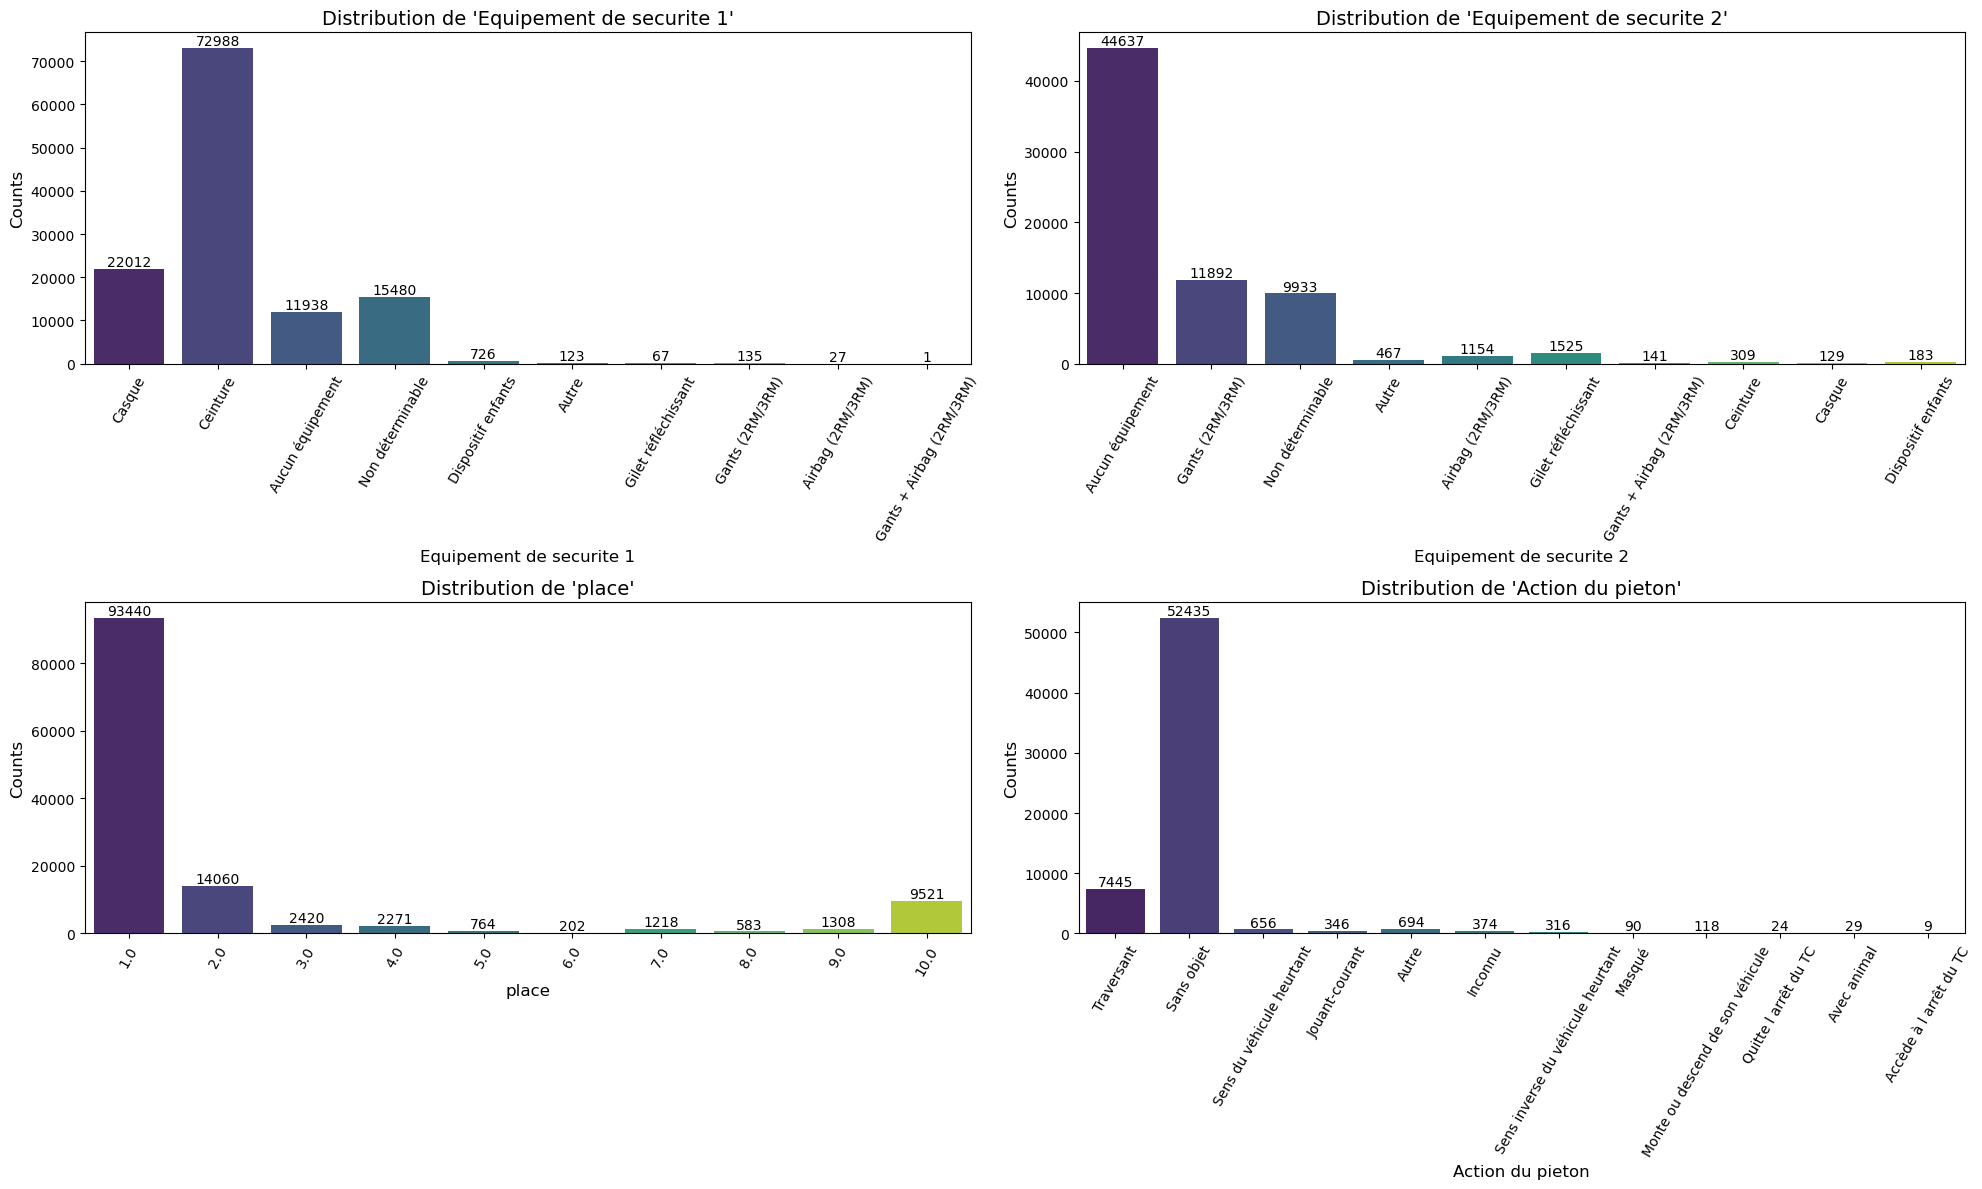

In [82]:
plot_all_distributions1(df_usagers, columns2)

En examinant la répartition des dispositifs de sécurité secu1, on constate que la ceinture 
de sécurité est l'équipement le plus fréquemment utilisé, avec 72988 des usagers tandis que les dispositifs pour enfants représentent 
une part marginale, à 726 utilisations.

Par suite, on observe de part la représentation de la variable "secu2" que une grande majorité des usagers n'utilisent pas un deuxième équipement de sécurité. Ils se contentent d'un seul équipement. Pour ceux qui en ont, ils portent des gangs en plus ou bien des équipements non déterminables pour la plupart. Les autres équipements et les combinaisons airbag personnel + gants (2/3 RM) sont les moins utilisés (467 et 141 utilisations respectivement). Cependant pour cette variable, les observations pourrait ne pas refléter la tendance réelle dans la population des accidentés enregistrés à cause de la forte proportion de valeurs manquantes.

La variable "place" indique la position occupée par les usagers dans le véhicule au moment de l’accident. Les résultats montrent que la majorité des usagers se trouvent en position "1" (93440 usagers) au moment de l'accident, correspondant probablement au conducteur, suivie par la position "2" (14 060 usagers), qui représente vraisemblablement un passager avant. La position "10", qui concerne les piétons, regroupe 9 521 individus, tandis que les positions "8" (583 usagers) et "6" (202 usagers), probablement liées à des sièges spécifiques à l’arrière ou à des configurations de véhicules moins fréquentes comme les transports en commun ou les deux-roues, affichent les plus faibles fréquences. Ces résultats pourraient s’expliquer par une plus grande exposition des conducteurs et passagers avant dans les accidents, alors que les places moins accessibles ou moins utilisées sont naturellement sous-représentées. La proportion notable de piétons illustre également leur vulnérabilité dans les accidents de la route.

De plus, pour la variable qui renseigne l'action du piéton, on observe une forte proportion d'actions sans objet, qui s'explique par le fait que cette variable n'est renseignée que pour les piétons (l'usager appartient à la catégorie des piétons). Donc pour un conducteur ou un passager, cette variable est manquante ou renseignée sans objet. Par exemple, 42% de valeurs manquantes de cette variable sont dû aux conducteurs comme on le montre par la suite. Pour les piétons (qui sont au nombre de 9521 usagers), près de 78% traversaient la route au moment de l'accident.Tandis que environ 7% se déplaçaient dans le sens du véhicule heurtant.

In [83]:
df_usagers[df_usagers["catu"]=="Conducteur"]["actp"].isnull().sum() / len(df_usagers)*100

np.float64(41.979823354983345)

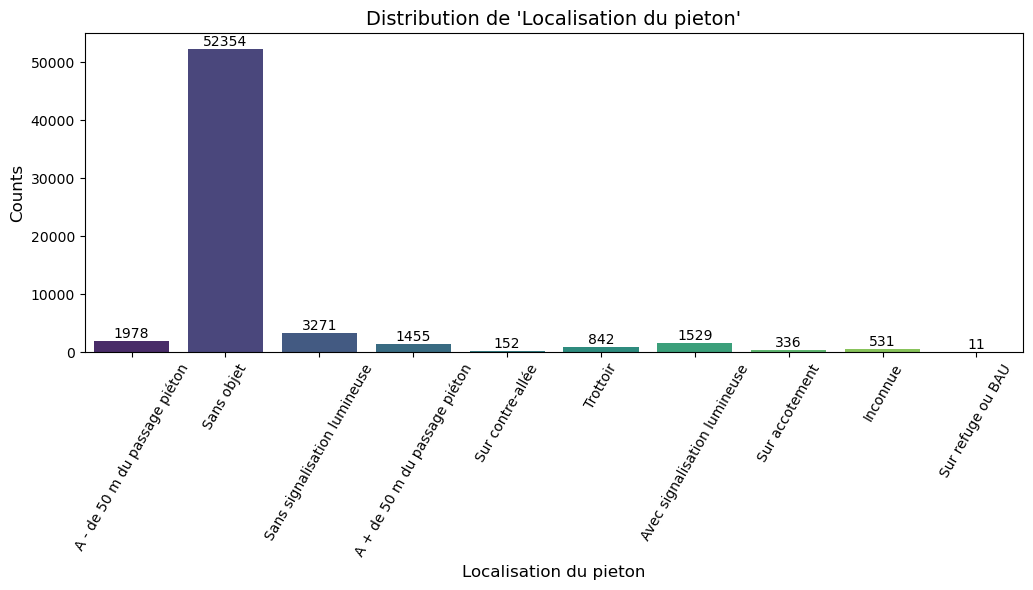

In [84]:
plot_all_distributions1(df_usagers, columns3)

Ici également on a une forte proportion des sans objets, qui see justifie comme précedemment.
La majorité des piétons se trouvaient dans des lieux sans signalisation lumineuse (34,35% des piétons), ensuite vient ceux qui se trouvaient à moins de 50 mètre du passage piéton (21%) puis ceux qui se trouvaient dans des zones à plus de 50 mètres du passage piéton (15%). La localisation précise de l'accident est inconnue dans moins de 6 % des cas, et seules de rares observations concernent des piétons sur des accotements (3,5 %) ou sur contre-allée (1,6 %).


Par suite, nous analysons le distribution de l'âge chez les usagers. Pour ce faire, nous utiliserons la variable qui donne l'année de naissance des usagers pour calculer l'âge de ces usagers en 2023.

╒═══════════════╤═══════════╕
│ Statistique   │    Valeur │
╞═══════════════╪═══════════╡
│ Nombre        │ 123191    │
├───────────────┼───────────┤
│ Moyenne       │     38.75 │
├───────────────┼───────────┤
│ Écart-type    │     19.1  │
├───────────────┼───────────┤
│ Min           │      0    │
├───────────────┼───────────┤
│ 25%           │     23    │
├───────────────┼───────────┤
│ 50% (médiane) │     35    │
├───────────────┼───────────┤
│ 75%           │     52    │
├───────────────┼───────────┤
│ Max           │    110    │
╘═══════════════╧═══════════╛


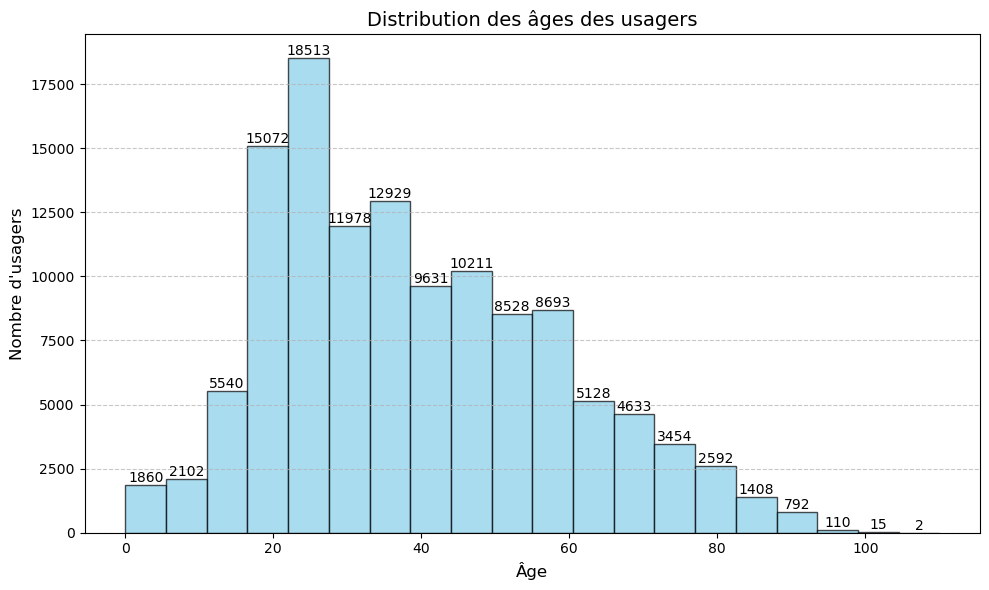

In [85]:
# Calcul de l'âge
df_usagers['age'] = 2023 - df_usagers['an_nais']
# Calcul des statistiques descriptives
age_stats = df_usagers['age'].describe()

age_summary = pd.DataFrame({'Statistique': ['Nombre', 'Moyenne', 'Écart-type', 'Min', '25%', '50% (médiane)', '75%', 'Max'],'Valeur': [int(age_stats['count']),round(age_stats['mean'], 2),round(age_stats['std'], 2),int(age_stats['min']),int(age_stats['25%']),int(age_stats['50%']),int(age_stats['75%']),int(age_stats['max']),]})
print(tabulate(age_summary, headers='keys', tablefmt='fancy_grid', showindex=False))
# Histogramme
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_usagers['age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
# Ajouter les chiffres au-dessus de chaque barre
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2,  # Position X au centre de la barre
             patches[i].get_height(),  # Position Y à la hauteur de la barre
             f'{int(n[i])}',  # Afficher le nombre d'usagers
             ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution des âges des usagers', fontsize=14)
plt.xlabel('Âge', fontsize=12)
plt.ylabel('Nombre d\'usagers', fontsize=12)
# Grille et ajustement
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

La population analysée, composée de 123 191 usagers, présente un âge moyen de 38,75 ans, avec une dispersion modérée (écart-type de 19,1 ans) 
et une médiane de 35 ans (la moitié des individus ont moins de 35 ans). La majorité des usagers se situe entre 23 ans (1er quartile) 
et 52 ans (3e quartile), avec des âges extrêmes allant de 0 à 110 ans, bien que ces valeurs puissent être biaisées par des valeurs abbérantes.
La distribution par tranche d'âge révèle une forte proportion de jeunes (11,2 % entre 10 et 19 ans) et une concentration probable dans les tranches d'âge actif (20-49 ans), tandis que les individus très âgés (100 ans et plus) restent marginaux (0,01 %). 
Ceci pourrait s'expliquer par le fait que ce sont les jeunes qui sont le plus souvent moins prudent sur la route, ou bien il peut s'agir de jeunes ayant eu leur permis il y a pas longtemps.

### 2)- Description de la base vehicules

La base des véhicules est constituée des variables d'identification et des variables catégorielles qui catérisent les véhicules impliqués dans les circulations routières comme la catégorie du véhicule, l'object fixe et mobile heurté par le véhicule, etc.

In [86]:
df_vehicules.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93585 entries, 0 to 93584
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Num_Acc      93585 non-null  int64  
 1   id_vehicule  93585 non-null  object 
 2   num_veh      93585 non-null  object 
 3   senc         93585 non-null  int64  
 4   catv         93585 non-null  int64  
 5   obs          93585 non-null  int64  
 6   obsm         93585 non-null  int64  
 7   choc         93585 non-null  int64  
 8   manv         93585 non-null  int64  
 9   motor        93585 non-null  int64  
 10  occutc       838 non-null    float64
dtypes: float64(1), int64(8), object(2)
memory usage: 7.9+ MB


In [87]:
for column in df_vehicules.columns:
    df_vehicules[column] = df_vehicules[column].replace(-1, np.nan)
    df_vehicules[column] = df_vehicules[column].replace(' -1', np.nan)
    
missing_percentage = (df_vehicules.isnull().sum() / len(df_vehicules)) * 100
print("Pourcentage de valeurs manquantes par variable :")
print(missing_percentage)

Pourcentage de valeurs manquantes par variable :
Num_Acc         0.000000
id_vehicule     0.000000
num_veh         0.000000
senc            0.110060
catv            0.003206
obs             0.060907
obsm            0.049153
choc            0.061976
manv            0.039536
motor           0.193407
occutc         99.104557
dtype: float64


Les variables de cette base contiennent moins de valeurs manquantes à l'exception de la variable "occutc"(renseigne sur le nombre d'occupant dans les transports en commun) qui a plus de 99% de valeurs manquantes. Nous allons la supprimer dans la suite car elle n'apporte pas d'informations.

In [88]:
df_vehicules = df_vehicules.drop(["occutc"], axis=1)

Nous définissons le dictionnaire des variables pour cette base


In [89]:
#Sens de circulation 
senc_labels = {-1: 'Non renseigné', 0: 'Inconnu', 1: 'PK ou PR ou numéro d\'adresse postale croissant', 
            2: 'PK ou PR ou numéro d\'adresse postale décroissant', 3: 'Absence de repère'}
#obstacles_fixes_heurte
obs_labels = {-1: "Non renseigné", 0: "Sans objet", 1: "Véhicule en stationnement", 2: "Arbre", 3: "Glissière métallique", 4: "Glissière béton",
            5: "Autre glissière", 6: "Bâtiment, mur, pile de pont", 7: "Support de signalisation verticale ou poste d’appel d’urgence", 8: "Poteau",
            9: "Mobilier urbain", 10: "Parapet", 11: "Ilot, refuge, borne haute", 12: "Bordure de trottoir", 13: "Fossé, talus, paroi rocheuse",
            14: "Autre obstacle fixe sur chaussée", 15: "Autre obstacle fixe sur trottoir ou accotement", 16: "Sortie de chaussée sans obstacle", 
            17: "Buse – tête d’aqueduc"}
#Catégorie du véhicule
#1: véhicules à deux roues
#2: quadricycle
#3: engin lourd
#4: véhicule léger
#5: véhicule utilitaire
#7: transport en commun
#8: 3RM
#9: EDP
df_vehicules["catv"] = df_vehicules["catv"].replace([4,30,32,2,5,31,33,34],value=1)
df_vehicules["catv"] = df_vehicules["catv"].replace([36,35,3],value=2)
df_vehicules["catv"] = df_vehicules["catv"].replace([20,21, 13,14,15,16,17],value=3)
df_vehicules["catv"] = df_vehicules["catv"].replace([7,8,9],value=4)
df_vehicules["catv"] = df_vehicules["catv"].replace([10,11,12],value=5)
df_vehicules["catv"] = df_vehicules["catv"].replace([18,37,39,19,40,38],value=7)
df_vehicules["catv"] = df_vehicules["catv"].replace([41,42,43],value=8)
df_vehicules["catv"] = df_vehicules["catv"].replace([50,60],value=9)

catv_labels = { -1:"Non renseigné", 0: "Indéterminable", 1: "vehicules à deux roues", 2: "quadricycle",
        3: "engin lourd", 4: "vehicules léger",
        5: "vehicules utilitaire", 6: "Référence inutilisée depuis 2006 (side-car)", 7: "transport en commun",
        8: "3RM", 9: "EDP", 80: "VAE", 99: "Autre véhicule"}
#Obstacle mobile heurté
obsm_labels = {-1: "Non renseigné", 0: "Aucun", 1: "Piéton", 2: "Véhicule", 4: "Véhicule sur rail", 5: "Animal domestique", 6: "Animal sauvage",
        9: "Autre"}
#point_de_choc_initial
choc_labels = {-1: "Non renseigné", 0: "Aucun", 1: "Avant", 2: "Avant droit", 3: "Avant gauche", 4: "Arrière", 5: "Arrière droit", 6: "Arrière gauche",
         7: "Côté droit", 8: "Côté gauche", 9: "Chocs multiples (tonneaux)"}
#manoeuvre_principale_avant_accident
manv_labels= {-1: "Non renseigné", 0: "Inconnue", 1: "Sans changement de direction", 2: "Même sens, même file", 3: "Entre 2 files", 4: "En marche arrière",
        5: "A contresens", 6: "En franchissant le terre-plein central", 7: "Dans le couloir bus, dans le même sens", 8: "Dans le couloir bus, dans le sens inverse",
        9: "En s’insérant", 10: "En faisant demi-tour sur la chaussée", 11: "Changeant de file", 12: "Changeant de file", 13: "Déporté", 14: "Déporté",
        15: "Tournant", 16: "Tournant", 17: "Dépassant", 18: "Dépassant", 19: "Divers", 20: "Divers", 21: "Divers", 22: "Divers", 23: "Divers",
        24: "Divers", 25: "Divers", 26: "Divers"}

#type_motorisation_vehicule
motor_labels = {-1: "Non renseigné", 0: "Inconnue", 1: "Hydrocarbures", 2: "Hybride électrique", 3: "Electrique", 4: "Hydrogène", 5: "Humaine",
        6: "Autre"}

In [90]:
mapping_dict2 = {
    "senc": senc_labels,
    "catv": catv_labels,
    "obs": obs_labels,
    "choc": choc_labels,
    "obsm": obsm_labels,
    "manv": manv_labels,
    "motor": motor_labels,
}
mapping_apply(df_vehicules,mapping_dict2)

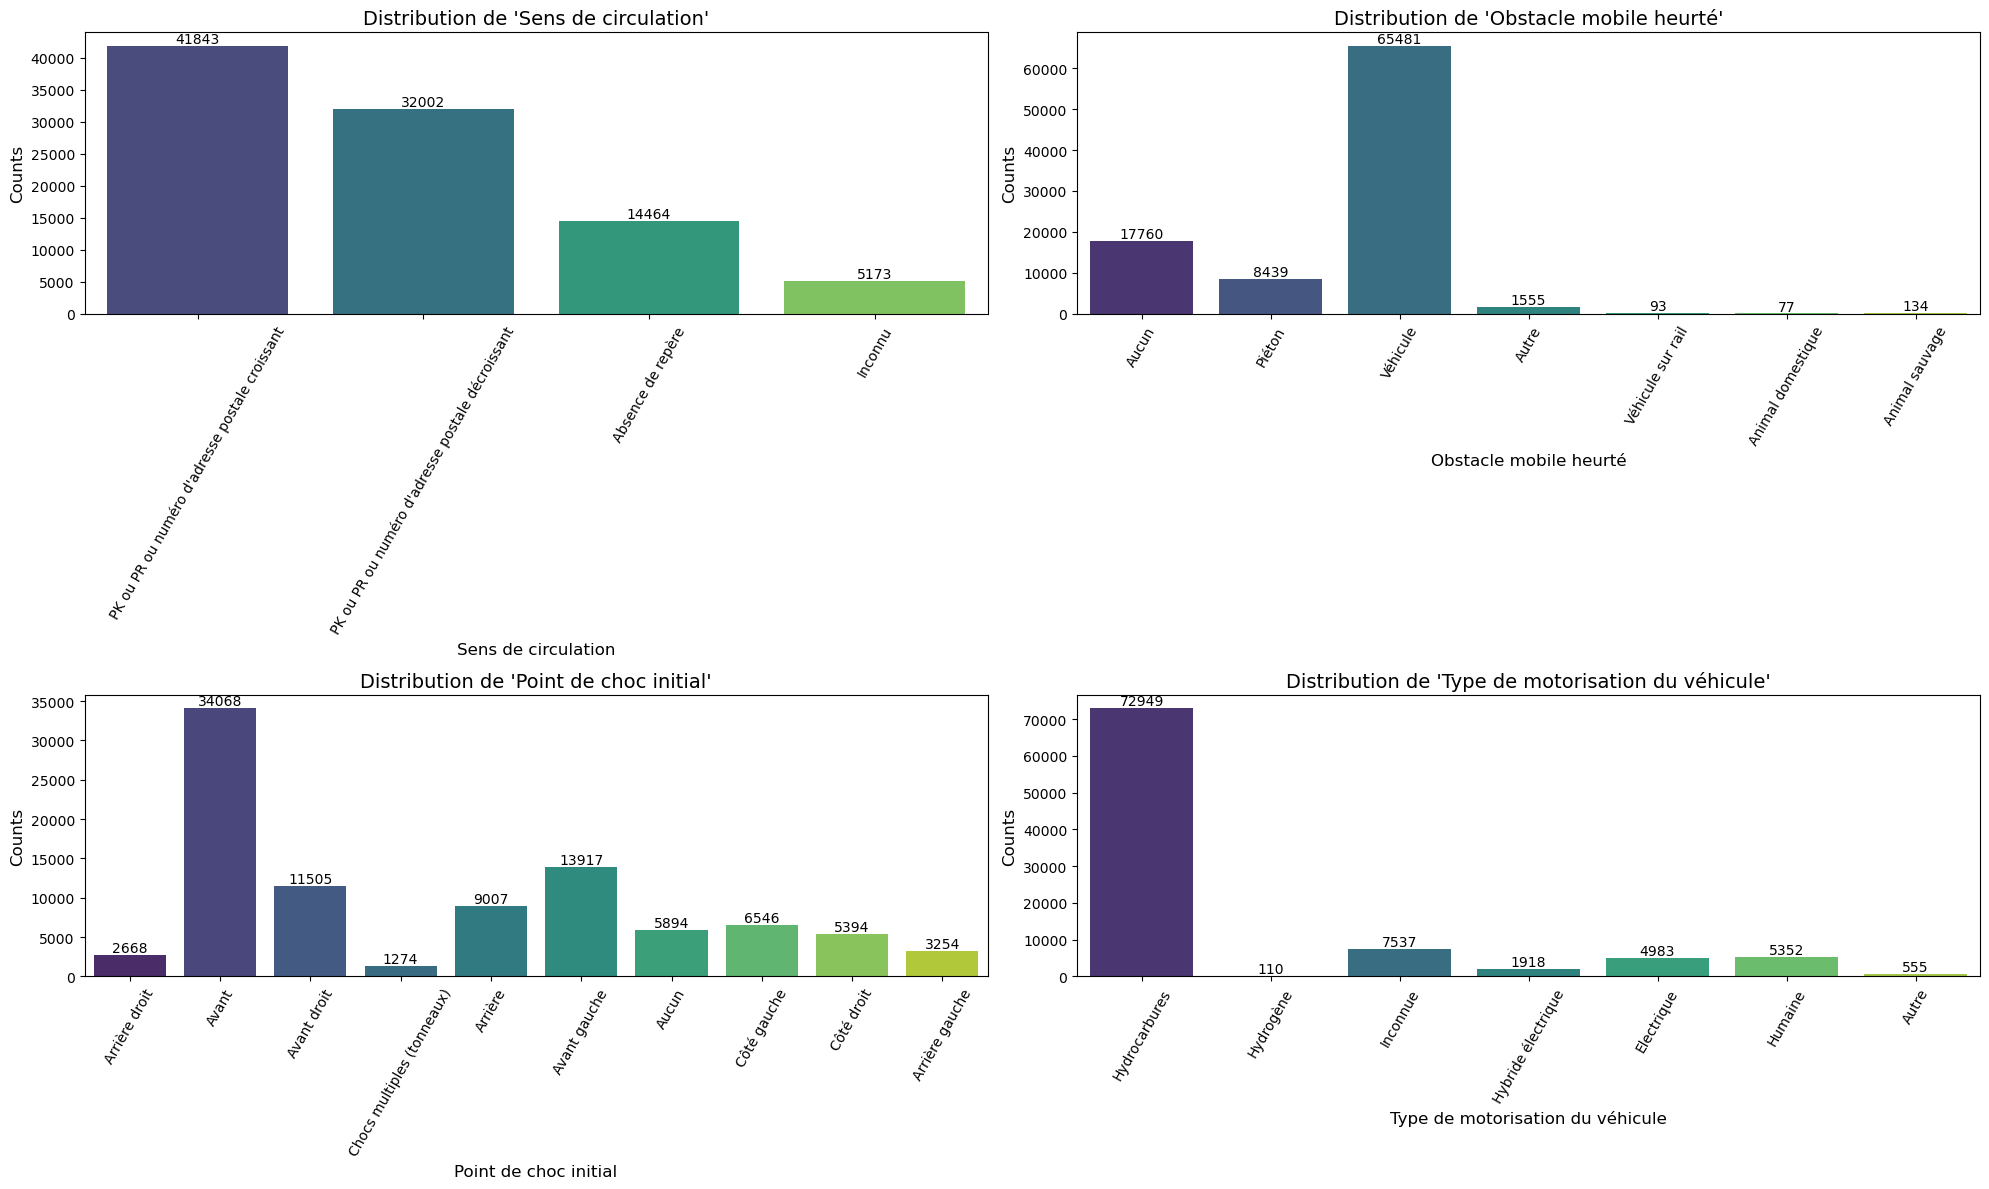

In [91]:
plot_all_distributions1(df_vehicules, ["senc", "obsm","choc", "motor"])

Dans la majorité des cas, l'accident a eu lieu dans un sens de circulation de point kilométrique (PK), ou point de repère (PR) ou numéro d'adresse postale croissant (41 843 cas), suivis des cas avec PK ou PR ou numéro d'adresse postale décroissant(32002). tandis qu'une proportion non négligeable (5 173 usagers) a été enregistrée avec un sens de circulation inconnu, ce qui pourrait refléter des lacunes dans la collecte des données ou des situations ambiguës, telles que des accidents survenus à des intersections, dans des zones non balisées, ou impliquant des usagers pour lesquels la direction était difficile à déterminer.

Concernant l'obstacle mobile heurté (obsm), dans la plupart des accidents l'objet mobile heurté est un véhicule. Ensuite, 17 760 véhicules n'ont pas heurté un obstacle mobile lors de l'accident (il pourrait s'agir plutôt d'obstacle fixe), et 9 349 véhicules ont heurté des piétons. Ces chiffres pourraient refléter un non-respect du code de la route ou des comportements imprudents. En revanche, une faible proportion des accidents est liée à des animaux domestiques (77 cas), des animaux sauvages (134 cas) et des véhicules sur rail (93 cas).

D'autre part, les chocs lors des accidents se produisent principalement à l’avant du véhicule (34 068 cas), suivis des collisions à l’avant gauche (13 917 cas) et à l’avant droit (11 505 cas), tandis que les chocs multiples (tonneaux) sont rares (1 274 cas), suggérant que les impacts frontaux sont les plus fréquents, mais que les risques graves, bien que moins fréquents, concernent surtout les accidents complexes et les collisions arrière droit (2 668 cas).

Par suite, la distribution du type de motorisation du véhicule montre une nette domination des véhicules à hydrocarbures, avec 72 949 occurrences, ce qui reflète leur omniprésence dans les transports actuels. Les motorisations alternatives, comme l'hydrogène (110 véhicules), les hybrides électriques (1 918 véhicules) et les électriques (4 983 véhicules), affichent des fréquences bien plus faibles, témoignant de leur adoption encore limitée. Les véhicules à propulsion humaine (5 352 cas) et les motorisations "inconnues" (7 537 cas) occupent une part non négligeable, ce qui pourrait s'expliquer par des catégories spécifiques de véhicules ou des limitations dans la collecte des données. Ces résultats traduisent la prédominance actuelle des véhicules thermiques tout en laissant entrevoir une légère diversification vers des alternatives plus écologiques.

In [92]:
def other_plot(df, column, title, xlabel, ylabel="Frequence", rotation=45, palette='viridis'):
    plt.figure(figsize=(20, 6))
    ax = sns.countplot(x=df[column], palette=palette)
    
    # Ajouter les chiffres sur les barres
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                    textcoords='offset points')
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    plt.show()


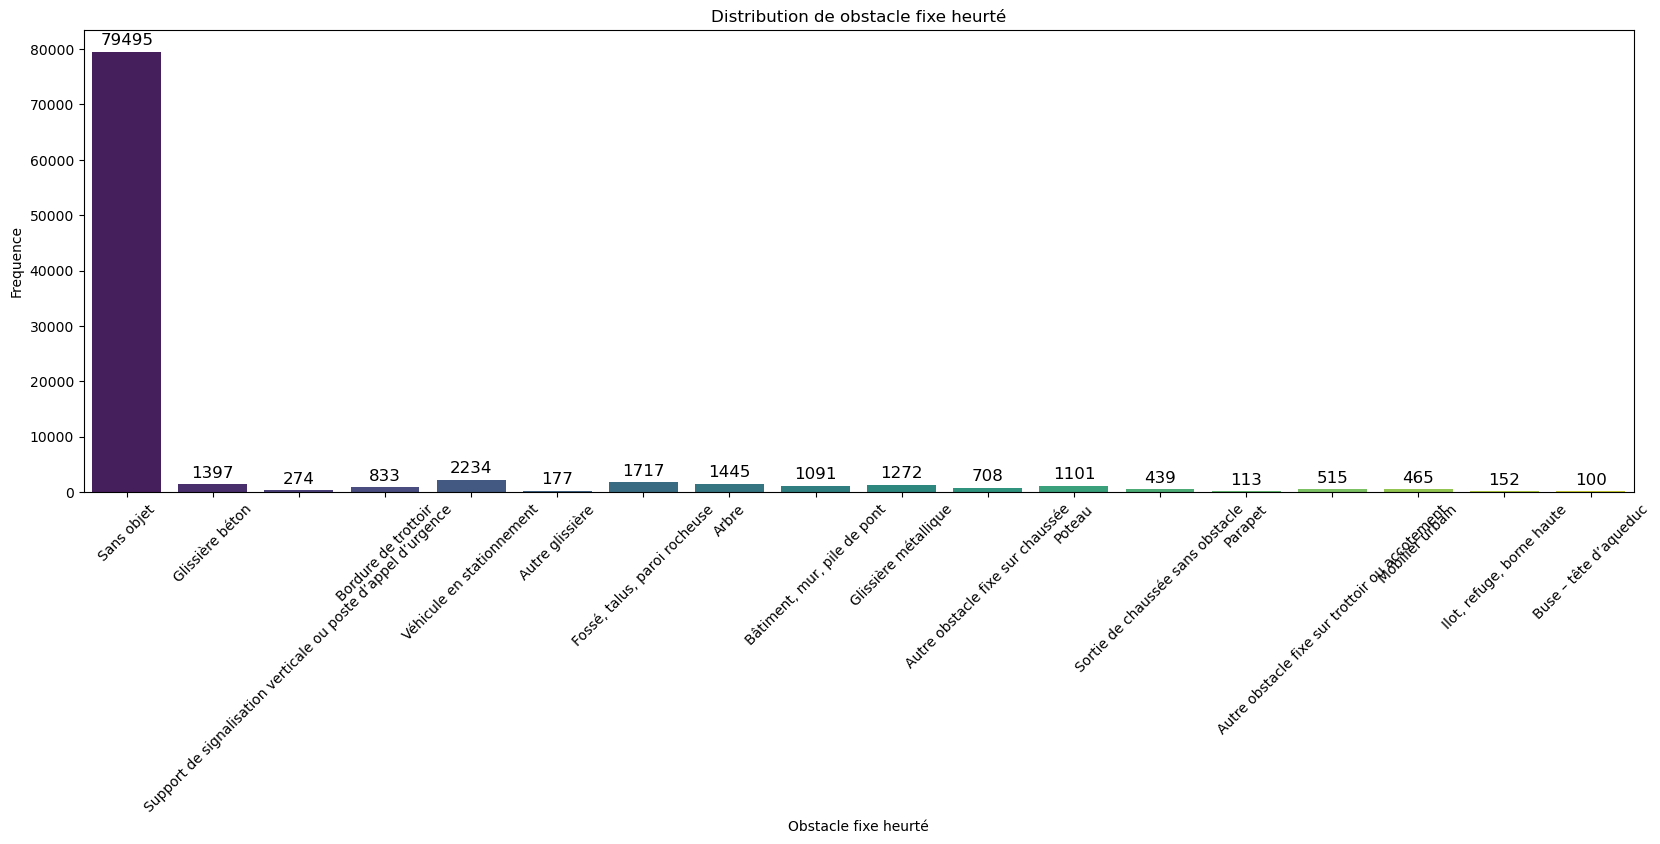

In [93]:
other_plot(df_vehicules, "obs", "Distribution de obstacle fixe heurté", "Obstacle fixe heurté")

On observe une prépondérance des valeurs sans objets qui après analyse de la base, s'interprète comme aucun obstacle fixe heurté ou bien non déterminé. Pour des véhicules qui ont heurté un obstacle mobile sans avoir heurté un obstacle fixe, la valeur pour cette variable est sans objet. Parmi les obstacles fixes les plus fréquemment heurtés, on trouve les véhicules en stationnement (2 234 cas), glissières de béton (1 397 cas), et les fossés, talus ou parois rocheuses (1 717 cas), tandis que les obstacles moins courants incluent des buses - têtes d'aqueduc (100 cas) et des îlots-refuges, bornes hautes (57 cas).

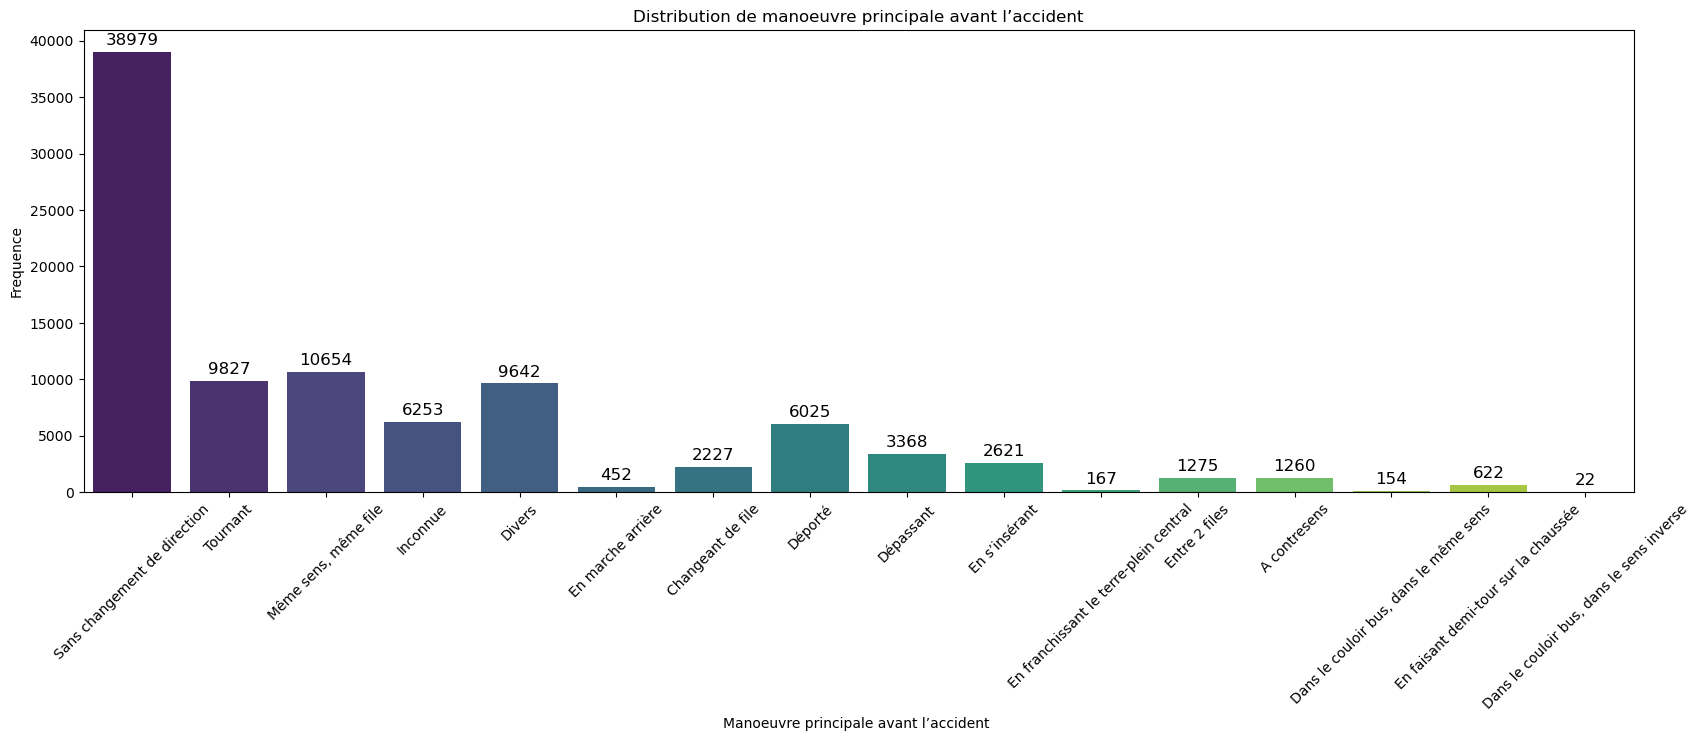

In [94]:
other_plot(df_vehicules, "manv", "Distribution de manoeuvre principale avant l’accident", "Manoeuvre principale avant l’accident ")

La distribution de la manœuvre principale avant l'accident révèle que la majorité des usagers n’effectuaient aucun changement de direction (38 979 cas), ce qui reflète une situation où les accidents surviennent principalement lors de trajets linéaires, sans manœuvres complexes. Les catégories "Même sens, même file" (10 654 cas) et "Tournant" (9 827 cas) représentent également des situations courantes, probablement dues à des erreurs dans des contextes de dépassement ou de virages. Les catégories "Inconnu" (6 253 cas) et "Déporté" (6 025 cas) indiquent des manœuvres moins précises ou des comportements inattendus avant l'accident. Enfin, les fréquences les plus faibles concernent des manœuvres spécifiques comme "Dans le couloir, dans le sens inverse" (22 cas) et "En marche arrière" (452 cas), ce qui peut s’expliquer par leur rareté dans les déplacements habituels. Ces résultats montrent que les accidents sont davantage liés à des situations de conduite courantes qu’à des manœuvres atypiques.

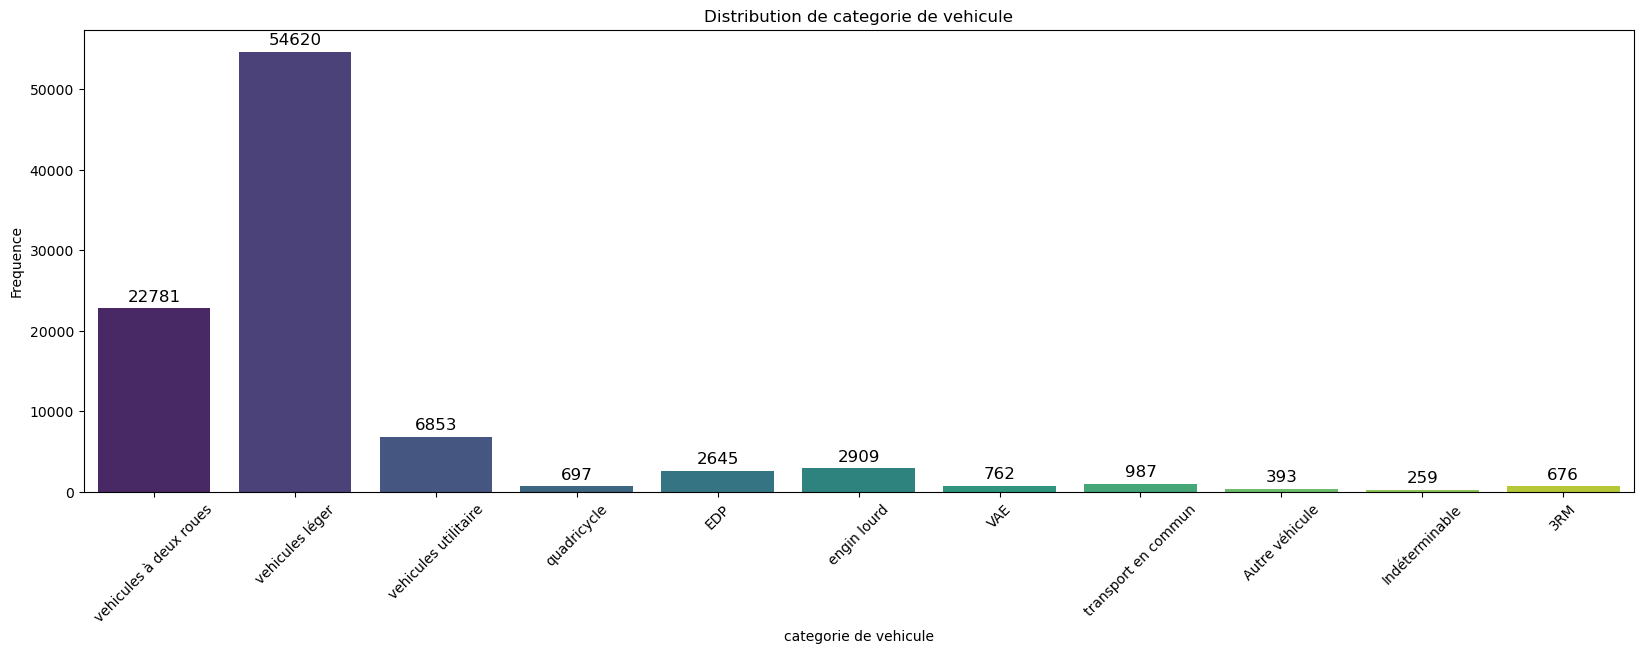

In [95]:
other_plot(df_vehicules, "catv", "Distribution de categorie de vehicule", "categorie de vehicule")

La distribution de la catégorie de véhicule (catv) montre une nette prédominance des véhicules légers seuls (VL seul), avec 54 620 cas, ce qui reflète leur rôle central dans la majorité des déplacements. Les catégories "EDP à moteur" (7 688 cas) et "Scooter > 50 cm3 et <= 125 cm3" (6 853 cas) occupent également des parts significatives (Non au sens de la théorie des tests), indiquant leur utilisation fréquente, notamment en milieu urbain. À l'inverse, les véhicules moins courants, comme les "Quads légers <= 50 cm3 (Quadricycles à moteur non carrossés)" (3 cas) et les "3 roues motorisées <= 50 cm3" (21 cas), affichent des fréquences extrêmement faibles. Ces résultats mettent en évidence une concentration des accidents impliquant des véhicules largement répandus et un risque plus limité pour des véhicules moins couramment utilisés, probablement en raison de leur usage spécifique ou restreint. 

### 3)- Description de la base des lieux

La base des lieux est constituée de la variable d'identification qui donne le numéro de l'accident, car l'accident a lieu dans un endroit précis, ainsi que des variables catégorielles qui caractérisent le lieu de l'accident telles que la catégorie de la route, l'infrastructure de la route, le regime de circulation, etc. Aussi, il y a des variables continues telles que le nombre de voie de la circulation sur la route, la vitesse maximale, etc.

In [96]:
df_lieux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70860 entries, 0 to 70859
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  70860 non-null  int64 
 1   catr     70860 non-null  int64 
 2   voie     58113 non-null  object
 3   v1       70860 non-null  int64 
 4   v2       5884 non-null   object
 5   circ     70860 non-null  int64 
 6   nbv      70860 non-null  object
 7   vosp     70860 non-null  int64 
 8   prof     70860 non-null  int64 
 9   pr       70860 non-null  object
 10  pr1      70860 non-null  object
 11  plan     70860 non-null  int64 
 12  lartpc   31 non-null     object
 13  larrout  70860 non-null  object
 14  surf     70860 non-null  int64 
 15  infra    70860 non-null  int64 
 16  situ     70860 non-null  int64 
 17  vma      70860 non-null  int64 
dtypes: int64(11), object(7)
memory usage: 9.7+ MB


In [97]:
for column in df_lieux.columns:
    df_lieux[column] = df_lieux[column].replace(-1, np.nan)
    df_lieux[column] = df_lieux[column].replace(' -1', np.nan)
    
missing_percentage = (df_lieux.isnull().sum() / len(df_lieux)) * 100
print("Pourcentage de valeurs manquantes par variable :")
print(missing_percentage)

Pourcentage de valeurs manquantes par variable :
Num_Acc     0.000000
catr        0.000000
voie       17.988992
v1         23.197855
v2         91.696303
circ        7.085803
nbv         5.860852
vosp        5.580017
prof        0.297770
pr         42.049111
pr1        42.314423
plan        0.231442
lartpc     99.956252
larrout    74.208298
surf        0.293537
infra       1.302568
situ        0.279424
vma         6.460627
dtype: float64


Plusieurs variables ont de fortes proportions de valeurs manquantes dans cette base. Néamoins toutes n'interviendront pas dans les analyses, notamment les variables "voie","v1","v2" qui servent à identifier la route. De plus la variable qui donne la largeur du terre plein centrale (lartpc) à 99% de valeurs manquantes tandis que celle qui donne la largeur de la chaussée affectée à la circulation des véhicules (larrout) à 74% de valeurs manquantes.


 Définissons le dictionnaire des variables.

In [98]:
catr_labels = {1: "Autoroute", 2: "Route nationale", 3: "Route départementale",4: "Voie communale", 5: "Hors réseau public",
        6: "Parc de stationnement", 7: "Routes de métropole urbaine", 9: "Autre"}

circ_labels = { 1: "À sens unique",  2: "Bidirectionnelle", 3: "À chaussées séparées", 4: "Avec voies d’affectation variable"}

vosp_labels = { 0: "Sans objet", 1: "Piste cyclable", 2: "Bande cyclable", 3: "Voie réservée"}

prof_labels = { 1: "Plat", 2: "Pente", 3: "Sommet de côte", 4: "Bas de côte"}

plan_labels = { 1: "Partie rectiligne", 2: "En courbe à gauche", 3: "En courbe à droite",4: "En 'S'"}

surf_labels = {  1: "Normale", 2: "Mouillée", 3: "Flaques", 4: "Inondée", 5: "Enneigée", 6: "Boue", 7: "Verglacée",
     8: "Corps gras – huile", 9: "Autre"}

infra_labels = { 0: "Aucun", 1: "Souterrain - tunnel", 2: "Pont - autopont", 3: "Bretelle d’échangeur", 4: "Voie ferrée",
     5: "Carrefour aménagé", 6: "Zone piétonne", 7: "Zone de péage", 8: "Chantier",9: "Autres"}

situ_labels = {0: "Aucun",1: "Sur chaussée",2: "Sur bande d’arrêt d’urgence",3: "Sur accotement",4: "Sur trottoir",
    5: "Sur piste cyclable", 6: "Sur autre voie spéciale", 8: "Autres"}

In [99]:
lum_labels = {1: "Plein jour",2: "Crépuscule ou aube", 3: "Nuit sans éclairage public", 4: "Nuit avec éclairage public non allumé",
    5: "Nuit avec éclairage public allumé"
}

agg_labels = {
    1: "Hors agglomération",
    2: "En agglomération"
}

int_labels = { 1: "Hors intersection", 2: "Intersection en X", 3: "Intersection en T", 4: "Intersection en Y", 5: "Intersection à plus de 4 branches",
    6: "Giratoire",7: "Place", 8: "Passage à niveau", 9: "Autre intersection"
}

atm_labels = { 1: "Normale", 2: "Pluie légère", 3: "Pluie forte", 4: "Neige - grêle", 5: "Brouillard - fumée",
     6: "Vent fort - tempête", 7: "Temps éblouissant", 8: "Temps couvert", 9: "Autre"
}

col_labels = { 1: "Deux véhicules - frontale", 2: "Deux véhicules – par l’arrière",3: "Deux véhicules – par le côté",
    4: "Trois véhicules et plus – en chaîne", 5: "Trois véhicules et plus - collisions multiples", 6: "Autre collision", 7: "Sans collision"
}

In [100]:
# mapping des variables
mapping_dict1 = {
    "catr": catr_labels,
    "circ": circ_labels,
    "vosp": vosp_labels,
    "prof": prof_labels,
    "plan": plan_labels,
    "agg": agg_labels,
    "col": col_labels,
    "atm": atm_labels,
    "situ": situ_labels,
    "infra": infra_labels,
    "surf": surf_labels}
    
mapping_apply(df_lieux, mapping_dict1)

Nous allons dans un premier temps observer le nombre d'accidents par type de route et la proportion des catégories de gravité par type de route. En effet cela permettra d'identifier les zones à risque et éventuellement de prioriser les mesures de sécurité adaptées.

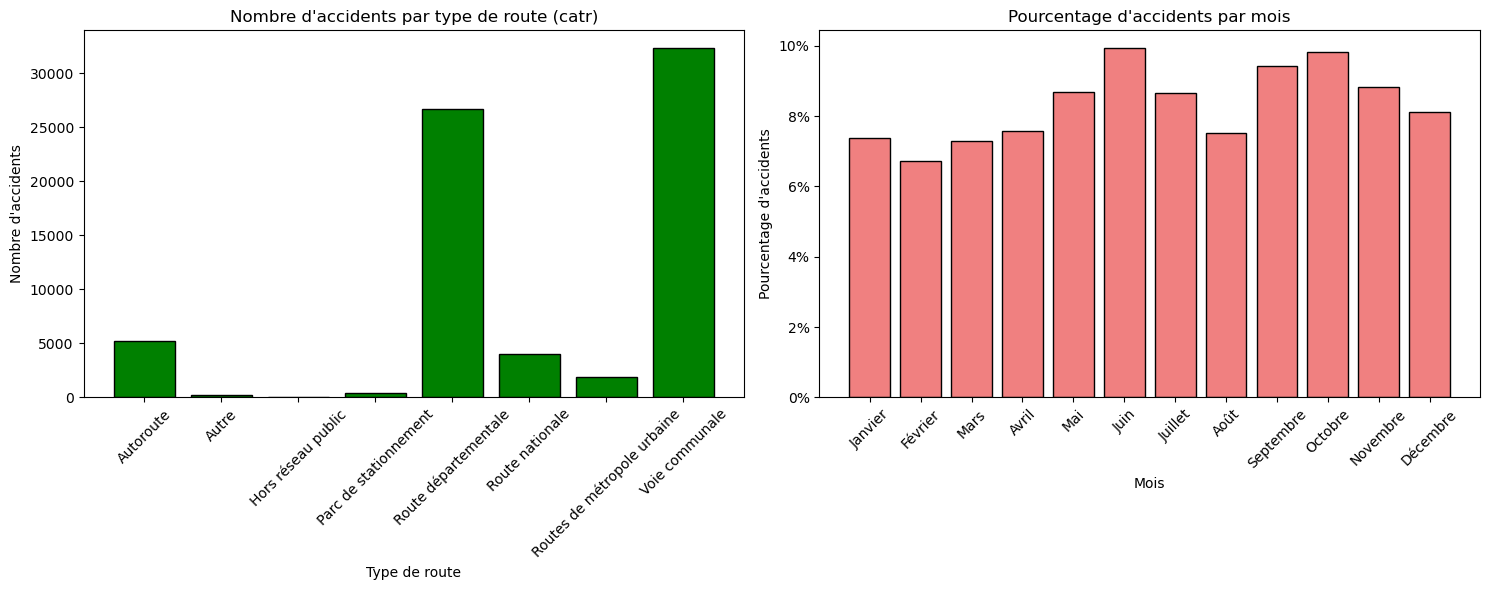

In [101]:
# Comptage des occurrences par catégorie de route
catr_counts = df_lieux['catr'].value_counts().sort_index()
catr_gravite_prop = (
    df_lieux.merge(df_usagers, on=["Num_Acc"], how="inner")
    .groupby(['catr', 'grav'])
    .size()
    .unstack(fill_value=0)
)

# Calcul des proportions par catégorie de route
catr_gravite_prop = catr_gravite_prop.div(catr_gravite_prop.sum(axis=1), axis=0)

# Création des deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Graphique 1 : Nombre d'accidents par type de route
axes[0].bar(catr_counts.index, catr_counts, color='green', edgecolor='black')
axes[0].set_title("Nombre d'accidents par type de route (catr)")
axes[0].set_xlabel("Type de route")
axes[0].set_ylabel("Nombre d'accidents")
axes[0].tick_params(axis='x', rotation=45)

#Graphique 2 :
# Calcul des pourcentages d'accidents par mois
mois_counts = df_caract['mois'].value_counts(normalize=True).sort_index() * 100

axes[1].bar(mois_counts.index, mois_counts, color='lightcoral', edgecolor='black')
axes[1].set_title("Pourcentage d'accidents par mois")
axes[1].set_xlabel("Mois")
axes[1].set_ylabel("Pourcentage d'accidents")
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels([
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin", 
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


De la distribution des accidents par type de route, on observe que: 
- Les **voies communales** et les **routes départementales** présentent le plus grand nombre d'accidents, avec une proportion nettement supérieure aux autres types de routes.
- Les **autoroutes** et les **routes nationales** ont beaucoup moins d'accidents en comparaison.
- Les types de routes comme le **parc de stationnement**, les **routes de métropole urbaine** et les routes **hors réseau public** ont des nombres d'accidents très faibles.

S'agissant de la distribution des accidents par mois, on constate une augmentation des accidents pendant les mois d'été (**mai, juin, juillet**), avec un pic en **juin**. Tandis que les mois d'hiver (**novembre, décembre, février**) enregistrent des pourcentages légèrement inférieurs.





Observons maintenant les conditions atmosphériques. 

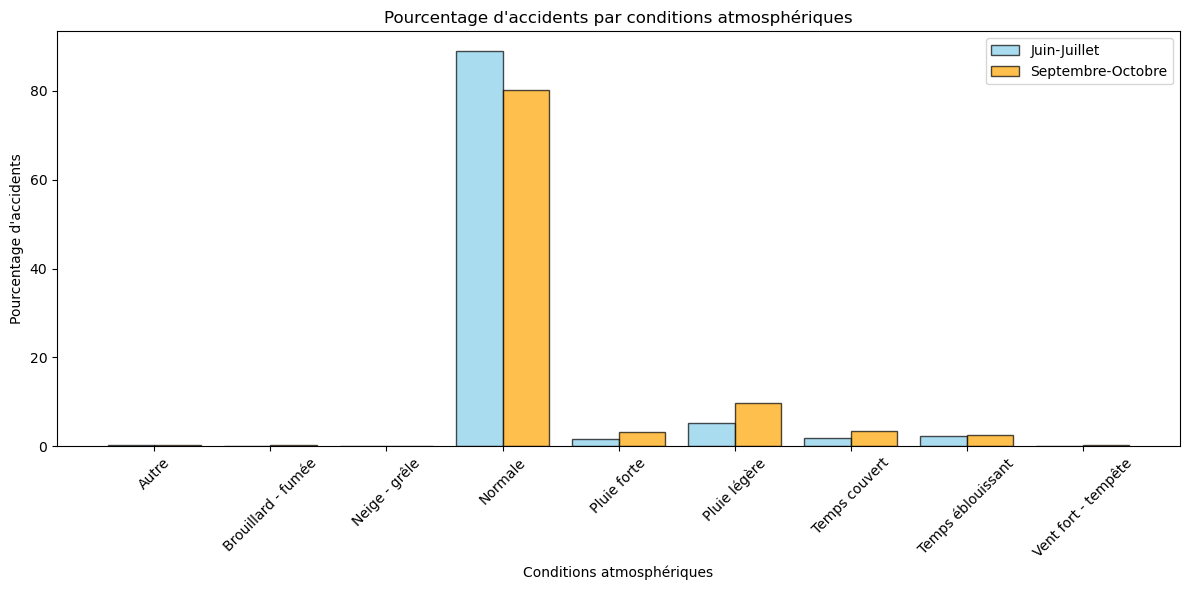

In [102]:
months_jj = [6, 7]
months_so = [ 9, 10]
# Créer des copies explicites des DataFrames filtrés
data_jj = df_caract[df_caract['mois'].isin(months_jj)].copy()
data_so = df_caract[df_caract['mois'].isin(months_so)].copy()

# Remplacer les indices par leurs labels AVANT de calculer les pourcentages
data_jj['atm_label'] = data_jj['atm'].map(atm_labels)
data_so['atm_label'] = data_so['atm'].map(atm_labels)

# Compter les accidents par conditions atmosphériques pour chaque groupe
atm_counts_jj = data_jj['atm_label'].value_counts().sort_index()
atm_counts_so = data_so['atm_label'].value_counts().sort_index()

# Calcul des pourcentages pour chaque groupe
total_jj = atm_counts_jj.sum()
total_so = atm_counts_so.sum()

jj_percentages = {label: (atm_counts_jj.get(label, 0) / total_jj) * 100 for label in atm_counts_jj.index}
so_percentages = {label: (atm_counts_so.get(label, 0) / total_so) * 100 for label in atm_counts_so.index}

# Préparation des données pour affichage côte à côte
combined_labels = sorted(set(atm_counts_jj.index).union(set(atm_counts_so.index)))
jj_values = [jj_percentages.get(label, 0) for label in combined_labels]
so_values = [so_percentages.get(label, 0) for label in combined_labels]

x = np.arange(len(combined_labels))  # Positions pour les groupes de barres

# Création du graphique
plt.figure(figsize=(12, 6))
bar_width = 0.4

# Barres pour Juin-Juillet
plt.bar(x - bar_width / 2, jj_values, bar_width, color='skyblue', edgecolor='black', label='Juin-Juillet', alpha=0.7)

# Barres pour Septembre-Octobre
plt.bar(x + bar_width / 2, so_values, bar_width, color='orange', edgecolor='black', label='Septembre-Octobre', alpha=0.7)

# Personnalisation du graphique
plt.title("Pourcentage d'accidents par conditions atmosphériques")
plt.xlabel("Conditions atmosphériques")
plt.ylabel("Pourcentage d'accidents")
plt.xticks(ticks=x, labels=combined_labels, rotation=45)
plt.legend()
plt.tight_layout()

# Affichage du graphique
plt.show()


Le graphique précédent montre une augmentation notable du nombre d'accidents pendant les mois de **juin, juillet** et **septembre, octobre**. Cela pourrait être lié à des périodes spécifiques de l'année :
- **Juin et juillet** correspondent aux mois de vacances, marqués par une augmentation des déplacements.
- **Septembre et octobre** coïncident avec la rentrée scolaire et professionnelle, entraînant une hausse de l'activité sur les routes.

En approfondissant l'analyse des conditions météorologiques pendant ces périodes, on constate que :
- Bien que les **conditions normales** (sans intempéries) restent majoritaires, les mois de **septembre-octobre** enregistrent une proportion plus élevée d'accidents survenant par **temps pluvieux**.

Ces observations pourraient encourager une exploration plus détaillée des interactions entre la météo et les comportements des usagers de la route pendant ces périodes.


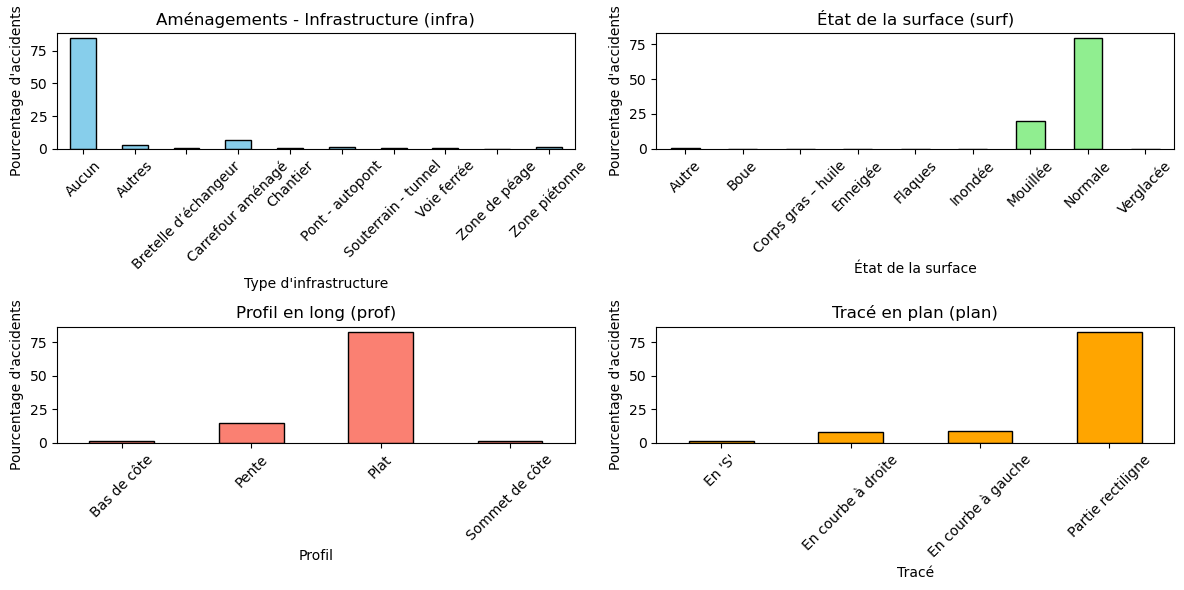

In [103]:
# Filtrage des données nécessaires pour l'analyse des infrastructures
infra_counts = df_lieux['infra'].value_counts().sort_index()
surf_counts = df_lieux['surf'].value_counts().sort_index()
prof_counts = df_lieux['prof'].value_counts().sort_index()
plan_counts = df_lieux['plan'].value_counts().sort_index()

# Calcul des pourcentages pour chaque variable
infra_percentages = (infra_counts / infra_counts.sum()) * 100
surf_percentages = (surf_counts / surf_counts.sum()) * 100
prof_percentages = (prof_counts / prof_counts.sum()) * 100
plan_percentages = (plan_counts / plan_counts.sum()) * 100

# Création des graphiques pour chaque variable
plt.figure(figsize=(12, 6))

# Graphique pour les infrastructures
plt.subplot(2, 2, 1)
infra_percentages.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Aménagements - Infrastructure (infra)")
plt.xlabel("Type d'infrastructure")
plt.ylabel("Pourcentage d'accidents")
plt.xticks(rotation=45)

# Graphique pour l'état de la surface
plt.subplot(2, 2, 2)
surf_percentages.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("État de la surface (surf)")
plt.xlabel("État de la surface")
plt.ylabel("Pourcentage d'accidents")
plt.xticks(rotation=45)

# Graphique pour le profil en long
plt.subplot(2, 2, 3)
prof_percentages.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Profil en long (prof)")
plt.xlabel("Profil")
plt.ylabel("Pourcentage d'accidents")
plt.xticks(rotation=45)

# Graphique pour le tracé en plan
plt.subplot(2, 2, 4)
plan_percentages.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Tracé en plan (plan)")
plt.xlabel("Tracé")
plt.ylabel("Pourcentage d'accidents")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


La majorité des accidents se produisent dans des zones sans infrastructure particulière **(Aucun)**, ce qui pourrait inclure des routes standard sans aménagements spécifiques.
Les infrastructures comme les Souterrains - tunnels, Ponts, ou Zones piétonnes enregistrent très peu d'accidents, probablement en raison d'une conception adaptée ou d'une moindre fréquentation.

*Hypothèse* : Les zones standard et non aménagées peuvent représenter des risques accrus, notamment en raison d'un manque de signalisation ou d'infrastructures de sécurité.

En outre, **l'état Normal** de la surface est de loin le plus fréquent pour les accidents, ce qui peut indiquer que la météo ou les conditions de la chaussée ne sont pas systématiquement les principaux facteurs. Les états Mouillée et d'autres conditions comme Verglacée ou Boueuse représentent une faible proportion d'accidents.

*Hypothèse* : Les accidents se produisent souvent dans des conditions normales, suggérant que d'autres facteurs comme la vitesse, l'inattention, ou les caractéristiques des routes (profil, plan) peuvent jouer un rôle important.

### 4)- Description de la base caract

La base des caractéristiques renseignent sur la situation spatiale, temporelle et météorologique au moment de l'accident. Elle est constitué de variables catégorielles et continues. 


In [104]:
df_caract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54822 entries, 0 to 54821
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  54822 non-null  int64 
 1   jour     54822 non-null  int64 
 2   mois     54822 non-null  int64 
 3   an       54822 non-null  int64 
 4   hrmn     54822 non-null  object
 5   lum      54822 non-null  int64 
 6   dep      54822 non-null  object
 7   com      54822 non-null  object
 8   agg      54822 non-null  int64 
 9   int      54822 non-null  int64 
 10  atm      54822 non-null  int64 
 11  col      54822 non-null  int64 
 12  adr      53433 non-null  object
 13  lat      54822 non-null  object
 14  long     54822 non-null  object
dtypes: int64(9), object(6)
memory usage: 6.3+ MB


Les variables **lat** et **long** qui donnent respectivement la latitude et la longitude  apparaissent comme des variables de type object car le séparateur de décimal n'est pas celui reconnu par python. Pour corriger cela, il suffit de remplacer les points par des virgules.

In [105]:
# Remplacer les virgules par des points et convertir en float
df_caract['lat'] = df_caract['lat'].str.replace(',', '.').astype(float)
df_caract['long'] = df_caract['long'].str.replace(',', '.').astype(float)

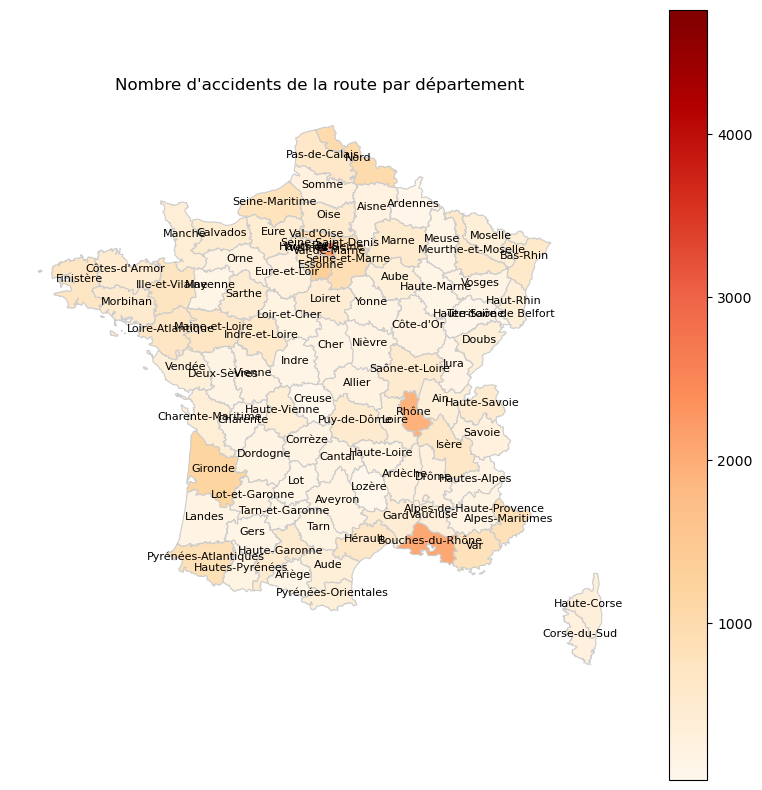

Departements avec le plus d'accidents :
   dep  nombre_accidents
75  75              4763
93  93              2650
92  92              2563
94  94              2204
12  13              2057


In [106]:
accidents_par_departement = df_caract.groupby('dep').size().reset_index(name='nombre_accidents')

france_map = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/departements.geojson")
france_map = france_map.merge(accidents_par_departement, left_on="code", right_on="dep")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
france_map.plot(column="nombre_accidents", cmap="OrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

#Ajout des noms de départements
for idx, row in france_map.iterrows():
    if not pd.isna(row['nom']):  # Vérifie que le nom est défini
        ax.annotate(
            text=row['nom'],  # Texte à afficher (nom du département)
            xy=row['geometry'].centroid.coords[0],  # Position (centre du département)
            ha='center', fontsize=8, color='black'  # Alignement et style
        )

plt.title("Nombre d'accidents de la route par département")
plt.axis("off")
plt.show()

# Trier les départements par nombre d'accidents en ordre décroissant
top_departements = accidents_par_departement.sort_values(by='nombre_accidents', ascending=False).head(5)

# Afficher les résultats
print("Departements avec le plus d'accidents :")
print(top_departements)



Les départements affichant des couleurs rouges foncées (notamment **Île-de-France**, **Rhône** et **Bouches-du-Rhône**) affichent un grand nombre d'accidents. Ceci pourrait s'expliquer par le fait que ces zones correspondent à des régions fortement urbanisées et densément peuplées, où le trafic routier est plus intense.
La majorité des départements, représentés en beige clair, présentent un nombre relativement faible d'accidents. Ces départements sont souvent situés dans des zones rurales ou moins peuplées, où la circulation est moins dense.

En terme de disparités régionales, les régions avec de grandes agglomérations présentent une concentration plus élevée d'accidents, ce qui est cohérent avec une densité de trafic plus importante.

Nous nous focalisons sur la distribution des accidents en île de france sur la carte suivante:

In [107]:
dep_IDF = ["75", "77", "78", "91", "92", "93", "94", "95"]
accidents_idf = df_caract[df_caract['dep'].isin(dep_IDF)]

# Définir le centre de l'Île-de-France (latitude et longitude moyennes)
center_lat = accidents_idf['lat'].mean()
center_long = accidents_idf['long'].mean()

# Créer la carte centrée sur l'Île-de-France
idf_map = folium.Map(location=[center_lat, center_long], zoom_start=10)

# Préparer les données pour la HeatMap (liste de coordonnées)
heat_data = accidents_idf[['lat', 'long']].values.tolist()

# Ajouter la HeatMap à la carte
HeatMap(heat_data, radius=10, blur=15, max_zoom=1).add_to(idf_map)

# Afficher la carte
idf_map


La carte précédente a mis en évidence une forte concentration d'accidents en Île-de-France. En nous focalisant davantage sur cette région, la nouvelle carte révèle une densité particulièrement élevée d'accidents dans **l'hypercentre de Paris**. Ces concentrations semblent se situer principalement le long des grands axes routiers, tels que les boulevards périphériques et les artères principales, qui sont les plus empruntés par les usagers. Cela pourrait s'explique par le flux important de véhicules et de piétons dans ces zones, où la densité de population et l'activité économique sont également les plus élevées.

Une question légitime est de savoir si le nombre d'accidents est directement corrélé à la population des départements. Pour y répondre, la carte suivante présente le nombre d'accidents rapporté au nombre d'habitants de chaque département. Avant de tracer la carte, nous calculons le nombre d'accident par habitant dans chaque département.

In [108]:
merged_df_dep = pd.merge(
    accidents_par_departement,
    df_population,
    left_on='dep',  # Nom de la colonne département dans accidents_par_departement
    right_on='Département',  # Nom de la colonne département dans df_population
    how='inner'
)

# Calcul du nombre d'accidents par habitant
merged_df_dep['accidents_par_habitant'] = merged_df_dep['nombre_accidents'] / merged_df_dep['Population']

print(merged_df_dep.head())


  dep  nombre_accidents Département Population accidents_par_habitant
0  01               382          01     674071               0.000567
1  02               253          02     523308               0.000483
2  03               235          03     333355               0.000705
3  04               193          04     167334               0.001153
4  05               201          05     141438               0.001421


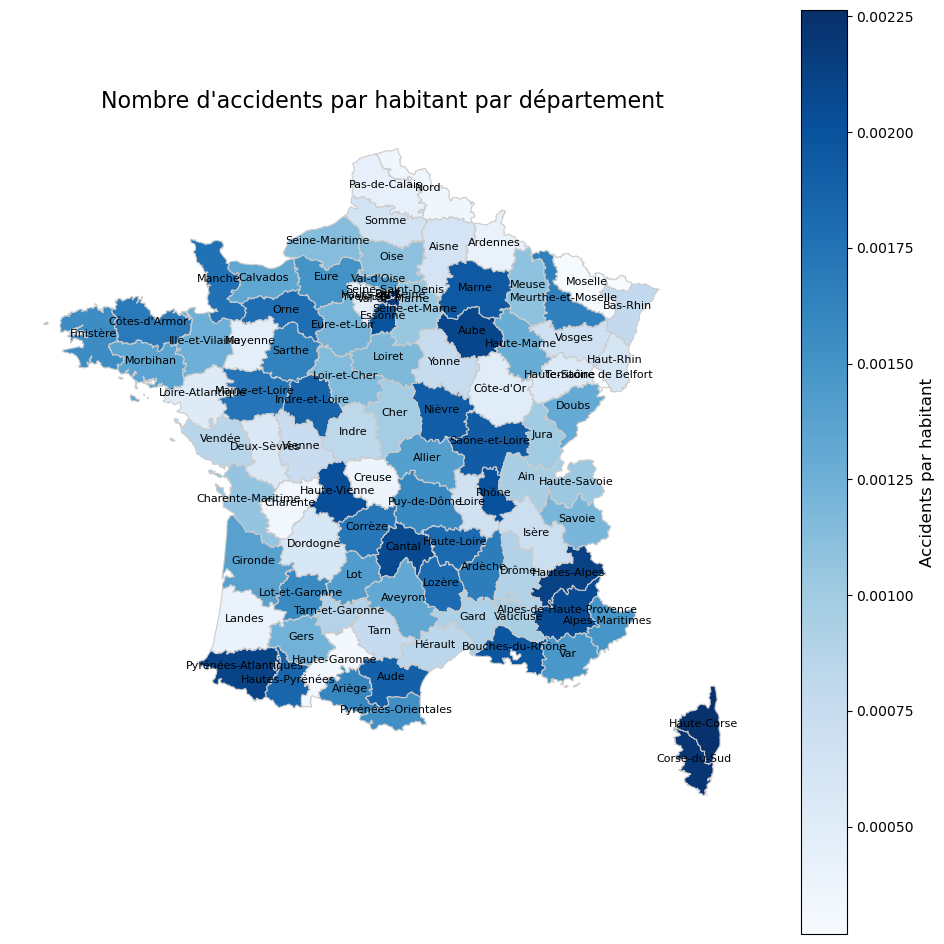

Les 5 départements avec le plus grand nombre d'accidents par habitant :
   Département accidents_par_habitant  nombre_accidents Population
75          75               0.002264              4763    2104154
29          2B               0.001853               346     186773
28          2A               0.001722               286     166078
93          93               0.001568              2650    1690411
92          92               0.001557              2563    1646445


In [109]:
france_map2 = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/departements.geojson")



france_map2 = france_map2.merge(merged_df_dep, left_on="code", right_on="dep", how="left")

# Vérifier les valeurs minimales et maximales de la colonne
vmin = merged_df_dep["accidents_par_habitant"].min()
vmax = merged_df_dep["accidents_par_habitant"].max()


# Création de la normalisation adaptée aux valeurs réelles
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)  
cmap = "Blues"  

# Création de la carte
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# Tracer la carte avec la normalisation
france_map2.plot(
    column="accidents_par_habitant",  # Colonne à visualiser
    cmap=cmap,                        # Palette de couleurs
    linewidth=0.8,                    # Épaisseur des frontières
    ax=ax,                            # Axes matplotlib
    edgecolor="0.8",                  # Couleur des frontières
    legend=False                      # Désactiver la légende automatique
)

# Ajout d'une légende avec la colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Accidents par habitant", fontsize=12)

# Ajout des noms de départements
for idx, row in france_map2.iterrows():
    if not pd.isna(row['nom']):  # Vérifie que le nom est défini
        ax.annotate(
            text=row['nom'],  # Texte à afficher (nom du département)
            xy=row['geometry'].centroid.coords[0],  # Position (centre du département)
            ha='center', fontsize=8, color='black'  # Alignement et style
        )

# Ajouter un titre et masquer les axes
plt.title("Nombre d'accidents par habitant par département", fontsize=16)
plt.axis("off")

# Afficher la carte
plt.show()

# Trier les départements par accidents par habitant en ordre décroissant
top_departments = merged_df_dep.sort_values(by='accidents_par_habitant', ascending=False).head(5)

# Afficher les colonnes pertinentes
print("Les 5 départements avec le plus grand nombre d'accidents par habitant :")
print(top_departments[['Département', 'accidents_par_habitant', 'nombre_accidents', 'Population']])




 Cette visualisation met en évidence que, bien que **Paris** conserve une nette première place en termes d'accidents par habitant, deux départements **corses** se distinguent également par un ratio élevé. Ces résultats contrastent avec ceux des départements plus peuplés comme le Rhône, qui, malgré un nombre absolu élevé d'accidents, affiche un ratio inférieur en raison de sa densité de population. Ces observations soulignent que les départements à faible population, comme en Corse, peuvent enregistrer des ratios élevés, potentiellement dus à des facteurs tels qu'une infrastructure routière limitée, des comportements à risque ou des spécificités géographiques. Une analyse plus approfondie serait nécessaire pour comprendre les causes sous-jacentes dans ces zones.

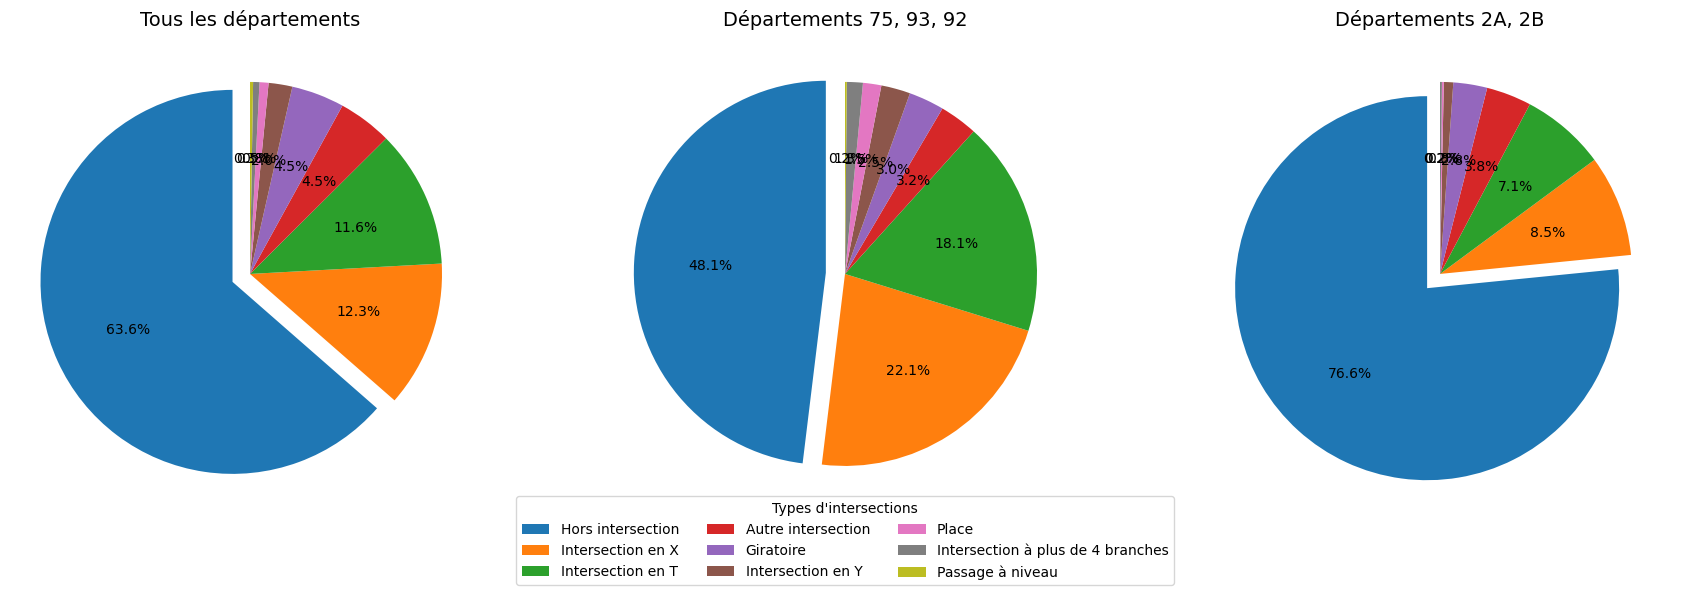

In [110]:
df_caract['int_label'] = df_caract['int'].map(int_labels)
# Compter le nombre d'accidents par type d'intersection pour chaque groupe
int_counts_all = df_caract['int_label'].value_counts()
filtered_75_93_92 = df_caract[df_caract['dep'].isin(['75', '93', '92'])]
int_counts_75_93_92 = filtered_75_93_92['int_label'].value_counts()
filtered_9A_9B = df_caract[df_caract['dep'].isin(['2A', '2B'])]
int_counts_9A_9B = filtered_9A_9B['int_label'].value_counts()

# Création des diagrammes circulaires
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Diagramme pour tous les départements
axes[0].pie(
    int_counts_all,
    autopct='%1.1f%%',
    startangle=90,
    labels=None,
    colors=plt.cm.tab10.colors,
    explode=[0.1 if i == int_counts_all.idxmax() else 0 for i in int_counts_all.index],
)
axes[0].set_title("Tous les départements", fontsize=14)

# Diagramme pour les départements 75, 93, 92
axes[1].pie(
    int_counts_75_93_92,
    autopct='%1.1f%%',
    startangle=90,
    labels=None,
    colors=plt.cm.tab10.colors,
    explode=[0.1 if i == int_counts_75_93_92.idxmax() else 0 for i in int_counts_75_93_92.index],
)
axes[1].set_title("Départements 75, 93, 92", fontsize=14)

# Diagramme pour les départements 2A et 2B
axes[2].pie(
    int_counts_9A_9B,
    autopct='%1.1f%%',
    startangle=90,
    labels=None,
    colors=plt.cm.tab10.colors,
    explode=[0.1 if i == int_counts_9A_9B.idxmax() else 0 for i in int_counts_9A_9B.index],
)
axes[2].set_title("Départements 2A, 2B", fontsize=14)

# Ajouter une légende commune sous la figure
fig.legend(
    labels=int_counts_all.index,  # Utiliser les labels globaux
    loc='lower center',  # Placer la légende en bas
    ncol=3,  # Nombre de colonnes dans la légende
    fontsize=10,
    title="Types d'intersections"
)

# Ajuster les espaces pour éviter la superposition
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Ajouter de l'espace en bas pour la légende
plt.show()


Les diagrammes montrent la répartition des accidents par type d’intersection à trois échelles : nationale, départements à forte densité urbaine (75, 92, 93), et départements à fort ratio accidents/habitants (2A, 2B).

Tous les départements
63,6 % des accidents se produisent hors intersection, ce qui domine largement.
Les intersections en X (12,3 %) et en T (11,6 %) concentrent la majorité des accidents restants, reflétant leur fréquence dans le réseau routier.
Départements 75, 92, 93 (zones urbaines)
La proportion d'accidents hors intersection baisse à 48,1 %, au profit des intersections en X (22,1 %) et en T (18,1 %).
Cela s’explique par la densité des carrefours et le trafic élevé dans ces zones.
Départements 2A, 2B (zones rurales/montagneuses)
Les accidents hors intersection augmentent à 76,6 %, en raison des routes sinueuses et du faible nombre d’intersections.
Les intersections en X et en T représentent une faible part (8,5 % et 7,1 %, respectivement).

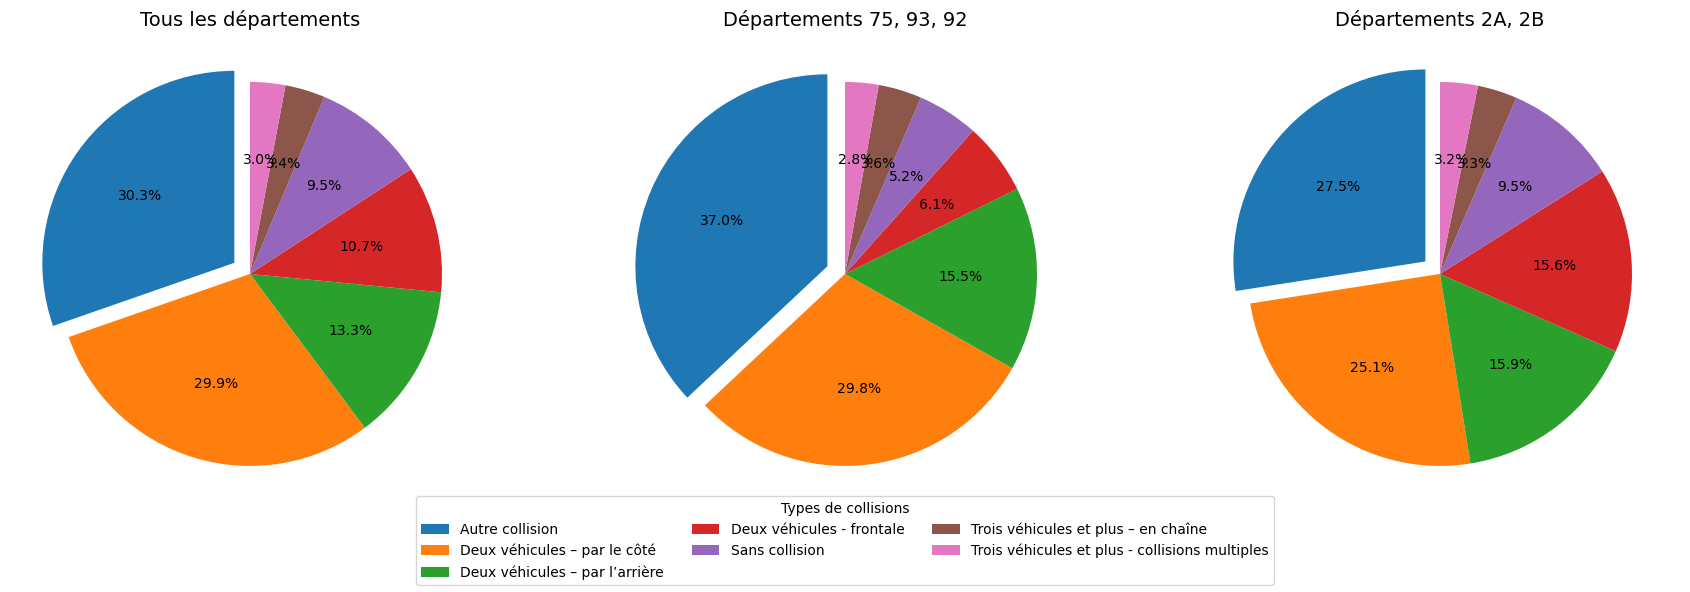

In [111]:
# Remplacer les valeurs de la colonne 'col' par leurs labels en utilisant le dictionnaire
df_caract['col_label'] = df_caract['col'].map(col_labels)

# Compter le nombre d'accidents par type de collision pour chaque groupe
col_counts_all = df_caract['col_label'].value_counts()
filtered_75_93_92 = df_caract[df_caract['dep'].isin(['75', '93', '92'])]
col_counts_75_93_92 = filtered_75_93_92['col_label'].value_counts()
filtered_2A_2B = df_caract[df_caract['dep'].isin(['2A', '2B'])]
col_counts_2A_2B = filtered_2A_2B['col_label'].value_counts()

# Création des diagrammes circulaires
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Diagramme pour tous les départements
axes[0].pie(
    col_counts_all,
    autopct='%1.1f%%',
    startangle=90,
    labels=None,
    colors=plt.cm.tab10.colors,
    explode=[0.1 if i == col_counts_all.idxmax() else 0 for i in col_counts_all.index],
)
axes[0].set_title("Tous les départements", fontsize=14)

# Diagramme pour les départements 75, 93, 92
axes[1].pie(
    col_counts_75_93_92,
    autopct='%1.1f%%',
    startangle=90,
    labels=None,
    colors=plt.cm.tab10.colors,
    explode=[0.1 if i == col_counts_75_93_92.idxmax() else 0 for i in col_counts_75_93_92.index],
)
axes[1].set_title("Départements 75, 93, 92", fontsize=14)

# Diagramme pour les départements 2A et 2B
axes[2].pie(
    col_counts_2A_2B,
    autopct='%1.1f%%',
    startangle=90,
    labels=None,
    colors=plt.cm.tab10.colors,
    explode=[0.1 if i == col_counts_2A_2B.idxmax() else 0 for i in col_counts_2A_2B.index],
)
axes[2].set_title("Départements 2A, 2B", fontsize=14)

# Ajouter une légende commune sous la figure
fig.legend(
    labels=col_counts_all.index,  # Utiliser les labels globaux
    loc='lower center',  # Placer la légende en bas
    ncol=3,  # Nombre de colonnes dans la légende
    fontsize=10,
    title="Types de collisions"
)

# Ajuster les espaces pour éviter la superposition
plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Ajouter de l'espace en bas pour la légende
plt.show()


- Répartition nationale
   * **Collisions par le côté (30,3%)** et **par l’arrière (29,9%)** dominent, reflétant des accidents fréquents dans des contextes de trafic dense.
   * Les accidents **sans collision (13,3%)** et **frontaux (9,5%)** complètent les principaux types.

- Zones urbaines (75, 92, 93)
   * **Autres collisions (37,0%)** majoritaires en raison du trafic intense et des interactions complexes.
   * Les collisions **par l’arrière (29,8%)** et **par le côté (15,5%)** restent importantes.
   * Les accidents **sans collision (6,1%)** sont rares.

- Zones rurales (2A, 2B)
   * Les accidents **sans collision (15,5%)** et **frontaux (9,5%)** sont plus fréquents, dus aux routes sinueuses.
   * Les collisions **par le côté** et **par l’arrière** sont moins fréquentes qu’en zones urbaines.


#### **Conclusion** 
Les voies départementales et communales concentrent la majorité des accidents en termes de volume. Cependant, les proportions de gravité sont similaires entre les types de routes, avec une prédominance des accidents indemnes et blessés légers. Les accidents mortels restent rares mais doivent être surveillés, en particulier sur les routes à plus forte circulation comme les routes nationales et départementales.

- Bien que le pourcentage d'accidents varie en fonction des saisons, la gravité moyenne des accidents est relativement constante.
- Une exploration approfondie des facteurs spécifiques (comme les conditions climatiques ou la densité de circulation) pourrait fournir des explications supplémentaires.

## **II- Relation variables-target**

Dans cette partie, il s'agira d'étudier l'association qui peut exister entre les variables et la gravité de l'accident routier. Ceci nous permettra de faire une sélection en amont des variables succeptible de mieux prédire la gravité.

### 1)- Analyse des diagrammes des profils

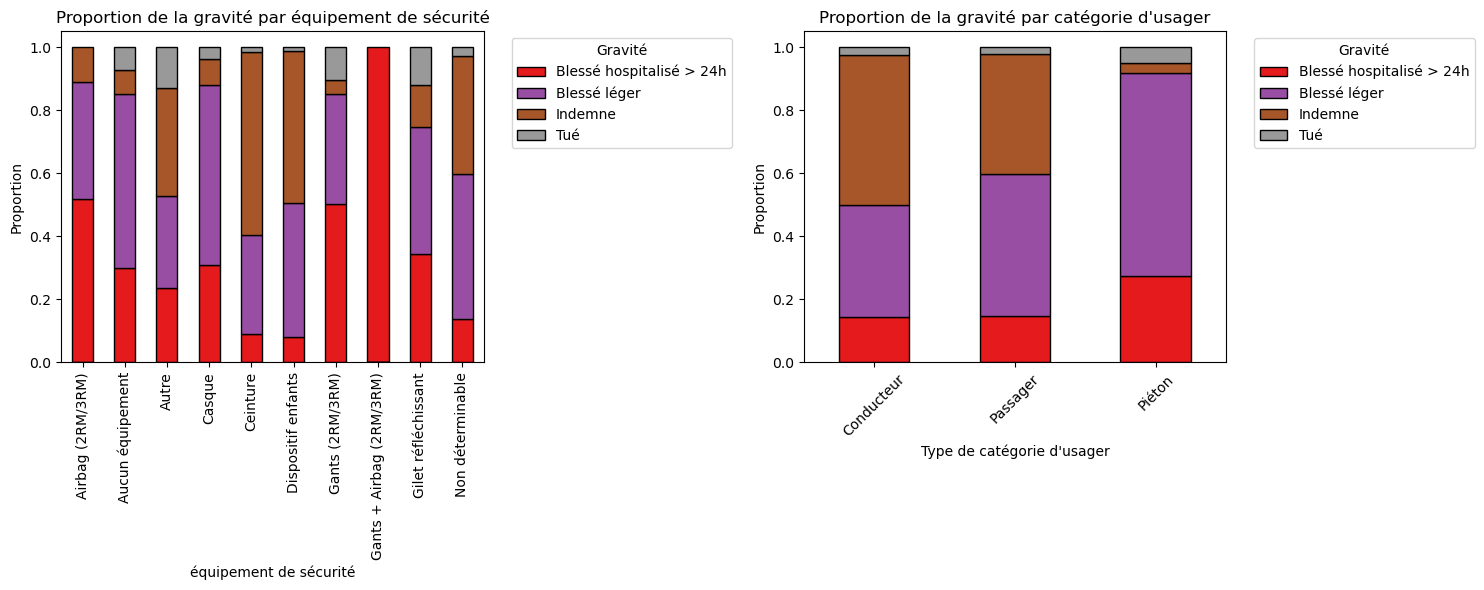

In [112]:
# Comptage des occurrences par catégorie de gravité et type de route
catu_gravite_prop = (
    df_usagers.groupby(['catu', 'grav'])
    .size()
    .unstack(fill_value=0)
)
# Calcul des proportions par catégorie de route
catu_gravite_prop = catu_gravite_prop.div(catu_gravite_prop.sum(axis=1), axis=0)

# Création des graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Graphique 2 : Proportion des catégories de gravité par type de route
catu_gravite_prop.plot( kind='bar', stacked=True, ax=axes[1], colormap='Set1',edgecolor='black')
axes[1].set_title("Proportion de la gravité par catégorie d'usager")
axes[1].set_xlabel("Type de catégorie d'usager")
axes[1].set_ylabel("Proportion")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')

# Comptage des occurrences par type de gravité et par mois
gravite_proportions_secu1 = (df_usagers.groupby(['secu1', 'grav']).size().unstack(fill_value=0))
# Calcul des proportions de gravité par mois
gravite_proportions_secu1 = gravite_proportions_secu1.div(gravite_proportions_secu1.sum(axis=1), axis=0)

# Graphique 1 : Proportion des types de gravité par mois
gravite_proportions_secu1.plot(kind='bar', stacked=True, ax=axes[0], colormap='Set1', edgecolor='black')
axes[0].set_title("Proportion de la gravité par équipement de sécurité")
axes[0].set_xlabel("équipement de sécurité")
axes[0].set_ylabel("Proportion")
axes[0].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')
# Ajustement de la mise en page
plt.tight_layout()
plt.show()

D'une part, le diagramme des profils pour le type d'équipement de sécurité montre que celui ci a un impact sur la gravité de l'accident. On observe que les proportions de blessés hospitalisés sont particulièrement élevées parmi les utilisateurs de casques (37,69 %) et de ceintures (32,00 %), tout en restant significatives pour ceux sans équipement (18,12 %). Concernant les décès, une part importante concerne les individus sans équipement (25,28 %), mais également les utilisateurs de casques (26,72 %) et de ceintures (32,65 %). À l’inverse, la majorité des personnes indemnes portaient une ceinture (79,17 %) ou utilisaient un dispositif pour enfants (61,67 %), suggérant une meilleure protection offerte par ces équipements. 

D'autre part, la catégorie d'usager semble être associée à la gravité de l'accident. On observe que 71,11 % des conducteurs blessés sont hospitalisés plus de 24 heures, 67,6 % subissent des blessures légères et 83,3 % sortent indemnes, bien que 71,8 % des conducteurs décèdent dans l'accident. Chez les passagers, 16,7 % sont hospitalisés plus de 24 heures, 20 % sont légèrement blessés, et 16,2 % sont indemnes, avec 14,2 % de passagers tués. Les piétons sont les usagers les plus vulnérables avec une proportion plus élevée de blessés graves et de décès. Ceci peut s'expliquer par le fait qu'ils sont directement exposés aux chocs lors d'un accident et ne bénéficient pas de la protection offerte par un véhicule. Tandis que les conducteurs et les passagers semblent être globalement mieux protégés.

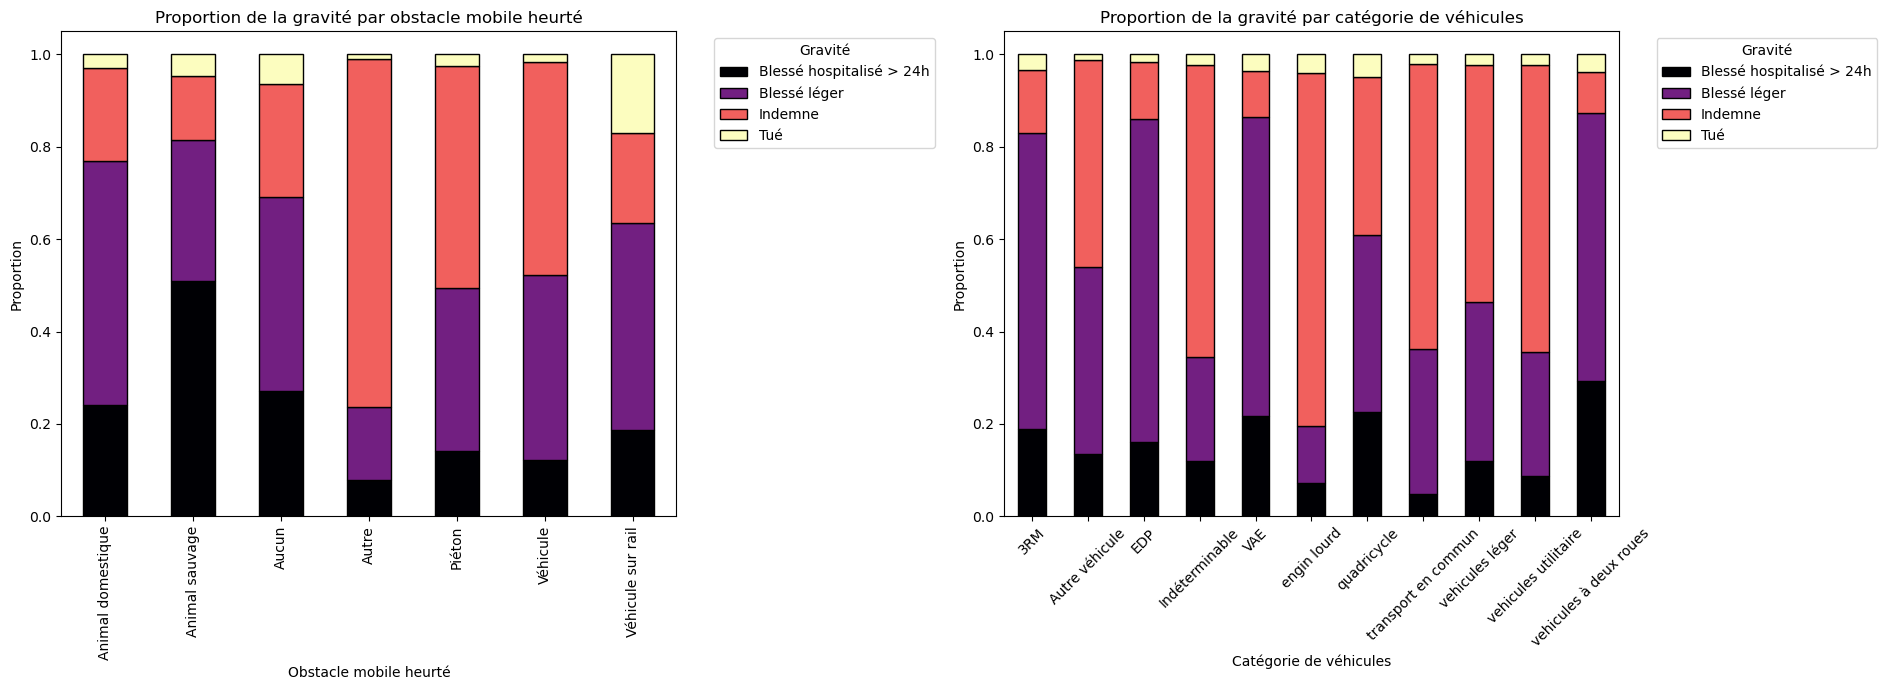

In [113]:
# Comptage des occurrences par catégorie de gravité et type de route
catv_gravite_prop = (
    df_vehicules.merge(df_usagers, on=["Num_Acc","id_vehicule","num_veh"], how="inner")
    .groupby(['catv', 'grav'])
    .size()
    .unstack(fill_value=0)
)
# Calcul des proportions par catégorie de route
catv_gravite_prop = catv_gravite_prop.div(catv_gravite_prop.sum(axis=1), axis=0)

# Création des graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(19, 7), sharey=False)

# Graphique 2 : Proportion des catégories de gravité par type de route
catv_gravite_prop.plot(kind='bar',stacked=True, ax=axes[1], colormap='magma',edgecolor='black')
axes[1].set_title("Proportion de la gravité par catégorie de véhicules")
axes[1].set_xlabel("Catégorie de véhicules")
axes[1].set_ylabel("Proportion")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')

# Comptage des occurrences par type de gravité et par mois
gravite_proportions_obsm = (
    df_vehicules.merge(df_usagers, on=["Num_Acc","id_vehicule","num_veh"], how="inner")
    .groupby(['obsm', 'grav'])
    .size()
    .unstack(fill_value=0)
)
# Calcul des proportions de gravité par mois
gravite_proportions_obsm = gravite_proportions_obsm.div(gravite_proportions_obsm.sum(axis=1), axis=0)

# Graphique 1 : Proportion des types de gravité par mois
gravite_proportions_obsm.plot(kind='bar',stacked=True, ax=axes[0],colormap='magma',edgecolor='black')
axes[0].set_title("Proportion de la gravité par obstacle mobile heurté")
axes[0].set_xlabel("Obstacle mobile heurté")
axes[0].set_ylabel("Proportion")

axes[0].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')
# Ajustement de la mise en page
plt.tight_layout()
plt.show()

L'analyse du tableau de profils montre une possible influence de la variable **"obstacle mobile heurté" (obsm)** sur la **"gravité de l'accident" (grav)**. Les collisions avec un **véhicule** sont les plus fréquentes, associées à des blessures légères (67,77 %) ou graves nécessitant une hospitalisation (55,05 %), mais aussi à des cas d'indemnes (71,66 %), indiquant que la gravité dépend probablement du contexte (vitesse, type de choc). Les accidents sans obstacle (43,57 %) et ceux impliquant des **piétons** (13,73 %) sont significativement associés aux décès, reflétant des facteurs externes ou la vulnérabilité des piétons. En revanche, les obstacles comme les animaux ou les véhicules sur rail ont une influence négligeable.

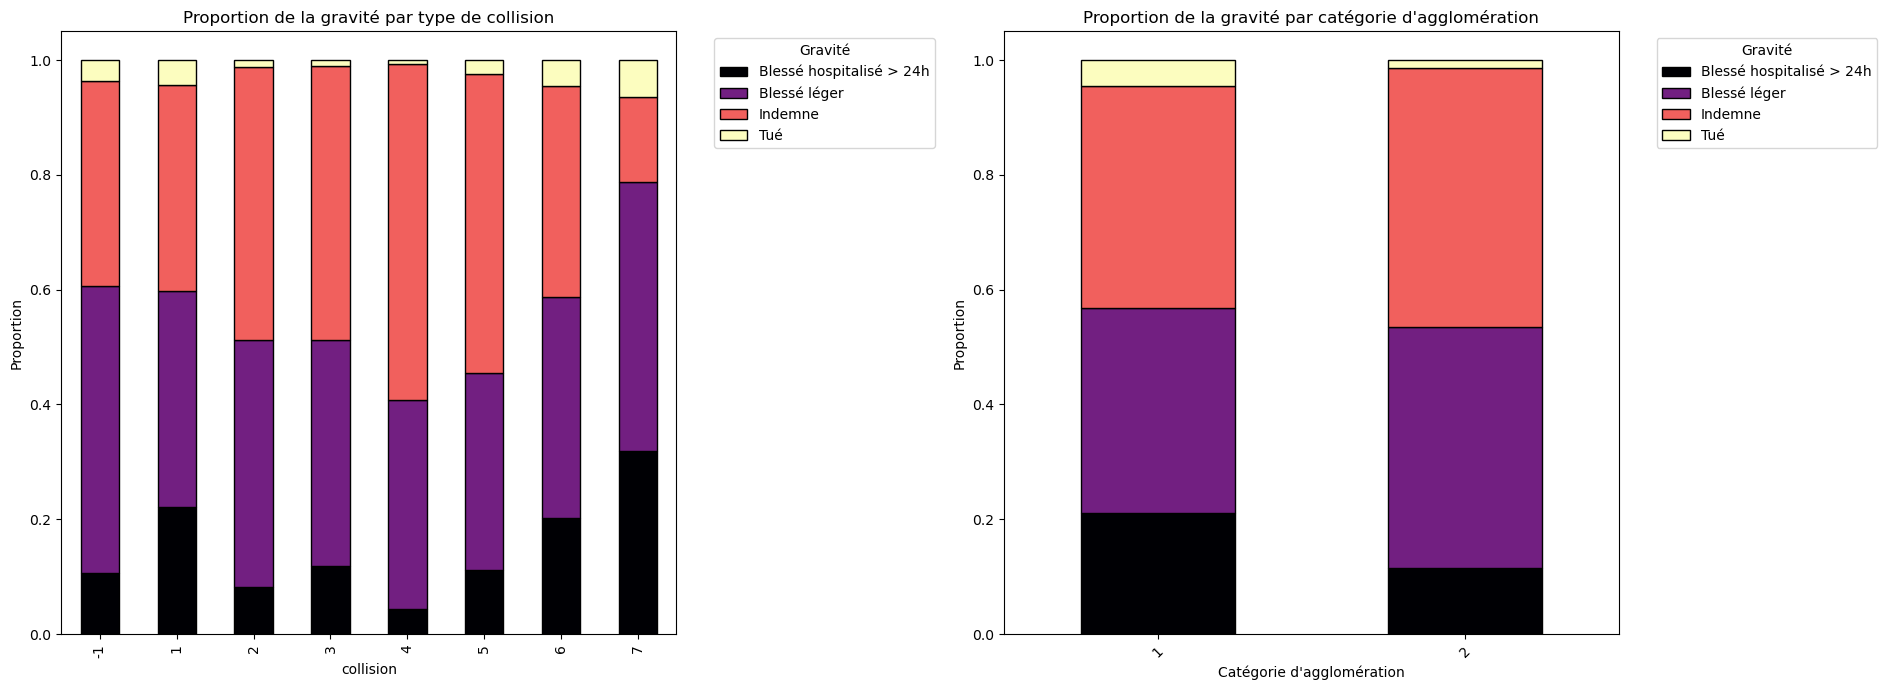

In [114]:
# Comptage des occurrences par catégorie de gravité et type de route
agg_gravite_prop = (
    df_caract.merge(df_usagers, on=["Num_Acc"], how="inner")
    .groupby(['agg', 'grav'])
    .size()
    .unstack(fill_value=0)
)
# Calcul des proportions par catégorie de route
agg_gravite_prop = agg_gravite_prop.div(agg_gravite_prop.sum(axis=1), axis=0)

# Création des graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(19, 7), sharey=False)

# Graphique 2 : Proportion des catégories de gravité par type de route
agg_gravite_prop.plot(kind='bar',stacked=True, ax=axes[1], colormap='magma',edgecolor='black')
axes[1].set_title("Proportion de la gravité par catégorie d'agglomération")
axes[1].set_xlabel("Catégorie d'agglomération")
axes[1].set_ylabel("Proportion")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')

# Comptage des occurrences par type de gravité et par mois
gravite_proportions_col = (
    df_caract.merge(df_usagers, on=["Num_Acc"], how="inner")
    .groupby(['col', 'grav'])
    .size()
    .unstack(fill_value=0)
)
# Calcul des proportions de gravité par mois
gravite_proportions_col = gravite_proportions_col.div(gravite_proportions_col.sum(axis=1), axis=0)

# Graphique 1 : Proportion des types de gravité par mois
gravite_proportions_col.plot(kind='bar',stacked=True, ax=axes[0],colormap='magma',edgecolor='black')
axes[0].set_title("Proportion de la gravité par type de collision")
axes[0].set_xlabel("collision")
axes[0].set_ylabel("Proportion")

axes[0].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')
# Ajustement de la mise en page
plt.tight_layout()
plt.show()

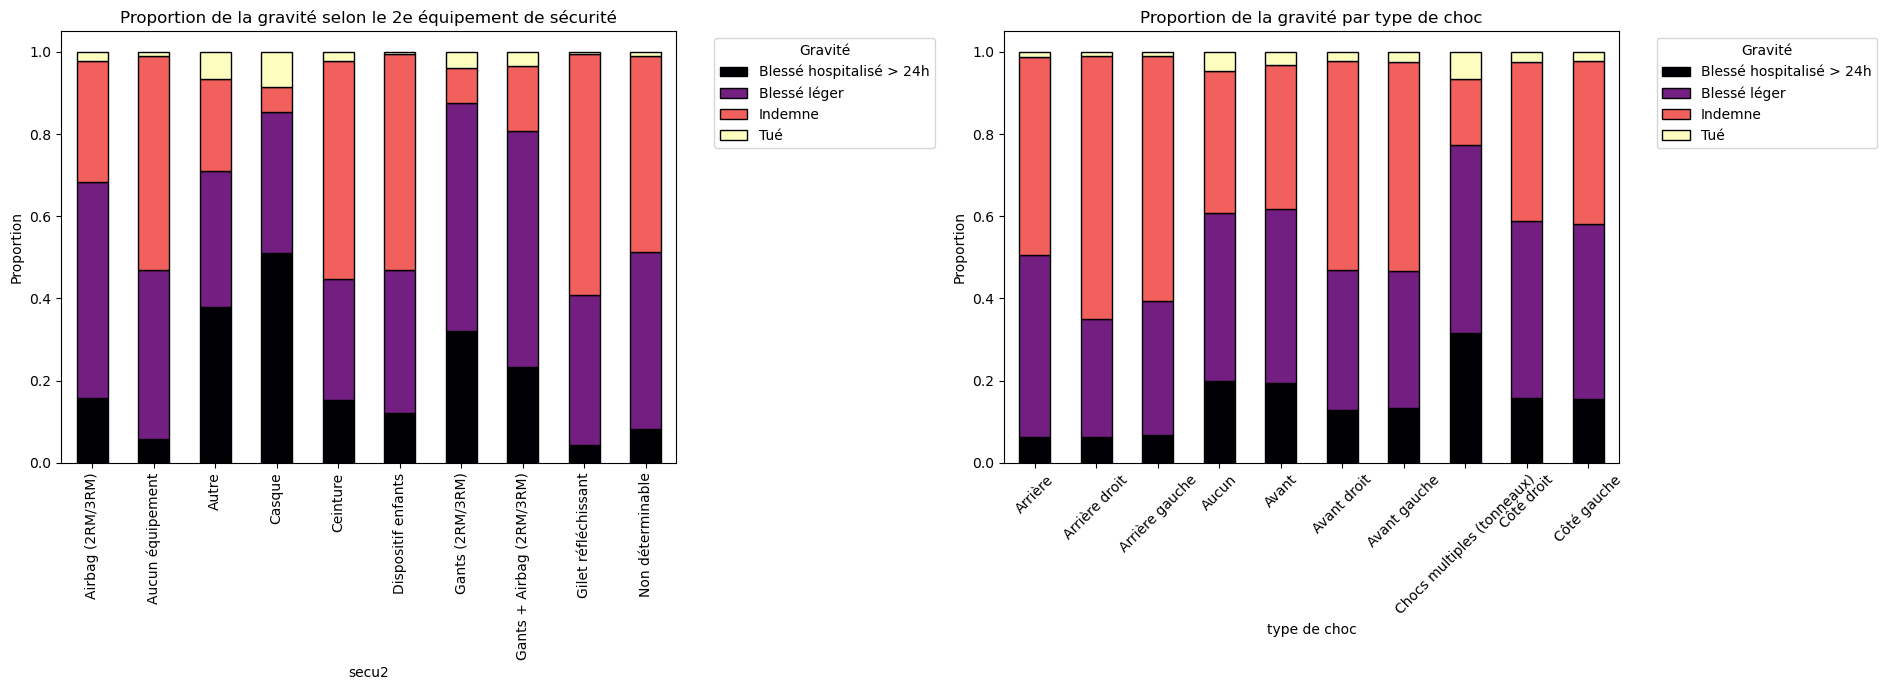

In [115]:
# Comptage des occurrences par catégorie de gravité et type de route
choc_gravite_prop = (
    df_vehicules.merge(df_usagers, on=["Num_Acc","id_vehicule","num_veh"], how="inner")
    .groupby(['choc', 'grav'])
    .size()
    .unstack(fill_value=0)
)
# Calcul des proportions par catégorie de route
choc_gravite_prop = choc_gravite_prop.div(choc_gravite_prop.sum(axis=1), axis=0)

# Création des graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(19, 7), sharey=False)

# Graphique 2 : Proportion des catégories de gravité par type de route
choc_gravite_prop.plot(kind='bar',stacked=True, ax=axes[1], colormap='magma',edgecolor='black')
axes[1].set_title("Proportion de la gravité par type de choc")
axes[1].set_xlabel("type de choc")
axes[1].set_ylabel("Proportion")
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')

# Comptage des occurrences par type de gravité et par mois
gravite_proportions_secu2 = (df_usagers.groupby(['secu2', 'grav']).size().unstack(fill_value=0))
    
# Calcul des proportions de gravité par mois
gravite_proportions_secu2 = gravite_proportions_secu2.div(gravite_proportions_secu2.sum(axis=1), axis=0)

# Graphique 1 : Proportion des types de gravité par mois
gravite_proportions_secu2.plot(kind='bar',stacked=True, ax=axes[0],colormap='magma',edgecolor='black')
axes[0].set_title("Proportion de la gravité selon le 2e équipement de sécurité")
axes[0].set_ylabel("Proportion")

axes[0].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')
# Ajustement de la mise en page
plt.tight_layout()
plt.show()

Gravité (grav) et équipement de sécurité2 (secu2)

Les données montrent que le type d’équipement de sécurité secondaire (secu2) semble également avoir une influence potentielle sur la gravité des blessures (grav). Les proportions de blessés hospitalisés sont particulièrement élevées parmi les utilisateurs de gants (49,53 %) et les personnes sans équipement (33,04 %), tandis qu’elles sont plus faibles pour les utilisateurs de ceintures (0,55 %) et de dispositifs pour enfants (0,26 %). Concernant les décès, les proportions sont élevées chez les utilisateurs de gants (44,41 %) et ceux sans équipement (36,80 %), ce qui suggère une vulnérabilité accrue dans ces groupes. À l’inverse, les proportions d’indemnes sont majoritairement observées chez les personnes sans équipement (76,53 %), suivies des utilisateurs de ceintures (55,51 %) et de dispositifs pour enfants (28,73 %), ce qui indique une meilleure protection relative pour ces derniers. Ces résultats suggèrent une corrélation probable entre l’équipement de sécurité secondaire utilisé et la gravité des blessures.

L'analyse du tableau montre une relation possible entre le **"point de choc initial" (choc)** et la **"gravité de l'accident" (grav)**. Les collisions frontales (**avant**) sont les plus fréquentes, représentant 46,99 % des blessés graves hospitalisés et 39,91 % des blessés légers, ainsi que 44,10 % des décès, indiquant que ces chocs sont particulièrement dangereux. Les chocs latéraux (**avant droit** et **avant gauche**) et ceux sur les **côtés** (droit et gauche) sont également associés à des blessures légères et graves, bien que moins mortels. Les chocs multiples (comme les tonneaux) montrent une proportion notable de blessés graves (2,80 %) et de décès (3,61 %), suggérant un risque accru dans ces cas. En revanche, les accidents sans point de choc précis (**aucun**) sont fortement associés aux décès (9,60 %), ce qui pourrait refléter des accidents impliquant une perte de contrôle ou d'autres facteurs imprécis. Ainsi, la localisation du choc initial semble jouer un rôle important dans la gravité des blessures, avec des chocs frontaux et multiples représentant les situations les plus critiques.

In [116]:
data=df_vehicules.merge(df_usagers, on=["Num_Acc","id_vehicule","num_veh"], how="inner")
contingency_table = pd.crosstab(data["grav"], data["motor"])
profile_table = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100
profile_table

motor,Autre,Electrique,Humaine,Hybride électrique,Hydrocarbures,Hydrogène,Inconnue
grav,,,,,,,
Blessé hospitalisé > 24h,0.649351,4.457143,6.623377,1.054545,79.579221,0.088312,7.548052
Blessé léger,0.537157,7.199111,7.546446,1.845719,75.848142,0.131260,6.892165
Indemne,0.698067,3.026834,0.910114,3.002439,82.644023,0.150122,9.568399
Tué,1.002063,3.153551,6.248158,1.178898,81.786030,0.029472,6.601827


L'analyse des profils de gravité des accidents en fonction du type de motorisation révèle que les véhicules à moteur à combustion (hydrocarbures) sont largement associés aux accidents les plus graves, représentant une proportion élevée de blessés hospitalisés plus de 24 heures, de blessés légers et de décès. Les motorisations "Electrique", "Humaine", "Hybride électrique" et "Hydrogène" semblent moins fréquentes dans les accidents graves, tandis que les catégories "Inconnue" et "Autre" montrent des valeurs intéressantes, notamment pour les décès. Ces résultats suggèrent que les véhicules à motorisation thermique sont plus susceptibles d'être impliqués dans des accidents graves. 

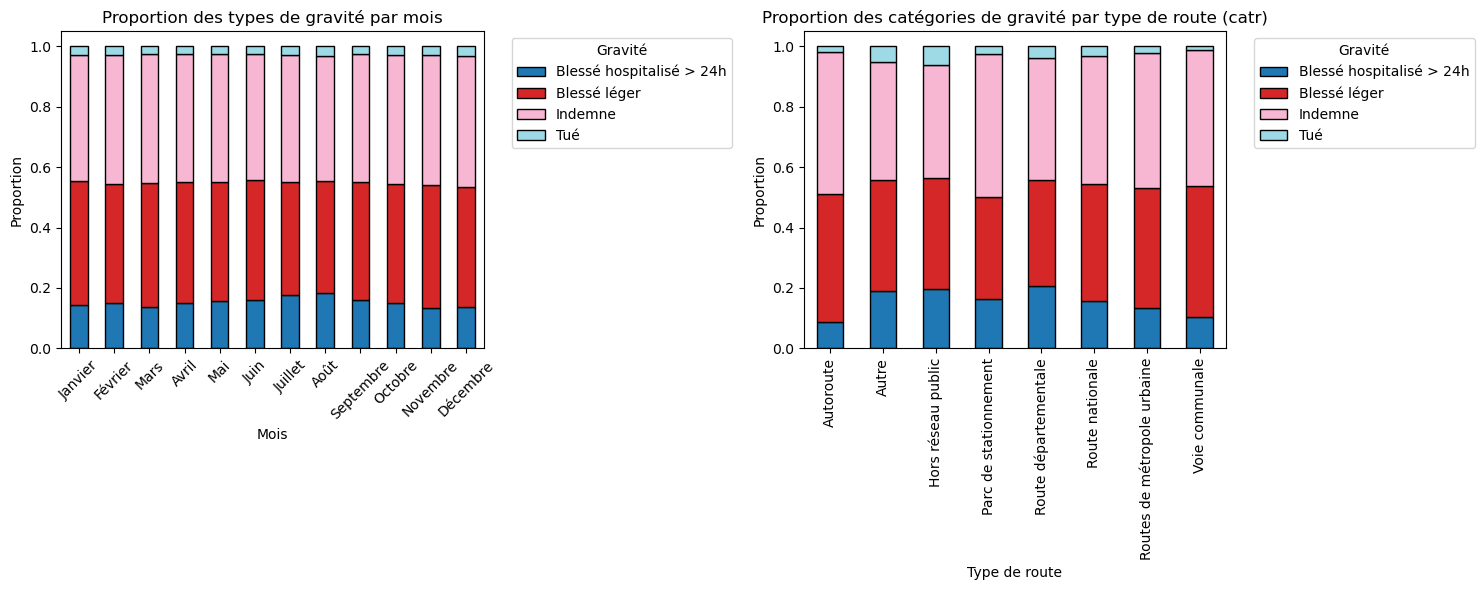

In [117]:
# Comptage des occurrences par catégorie de route
catr_counts = df_lieux['catr'].value_counts().sort_index()

# Comptage des occurrences par catégorie de gravité et type de route
catr_gravite_prop = (
    df_lieux.merge(df_usagers, on='Num_Acc')
    .groupby(['catr', 'grav'])
    .size()
    .unstack(fill_value=0)
)
# Calcul des proportions par catégorie de route
catr_gravite_prop = catr_gravite_prop.div(catr_gravite_prop.sum(axis=1), axis=0)

# Comptage des occurrences par type de gravité et par mois
gravite_proportions_mois = (
    df_caract.merge(df_usagers, on='Num_Acc')
    .groupby(['mois', 'grav'])
    .size()
    .unstack(fill_value=0)
)

# Calcul des proportions de gravité par mois
gravite_proportions_mois = gravite_proportions_mois.div(gravite_proportions_mois.sum(axis=1), axis=0)
# Création des graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Graphique 1 : Proportion des types de gravité par mois
gravite_proportions_mois.plot( kind='bar',stacked=True,ax=axes[0],colormap='tab20',edgecolor='black')
axes[0].set_title("Proportion des types de gravité par mois")
axes[0].set_xlabel("Mois")
axes[0].set_ylabel("Proportion")
axes[0].set_xticklabels([
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin", 
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
axes[0].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')

# Graphique 2 : Proportion des catégories de gravité par type de route
catr_gravite_prop.plot(kind='bar',stacked=True, ax=axes[1],  colormap='tab20', edgecolor='black')
axes[1].set_title("Proportion des catégories de gravité par type de route (catr)")
axes[1].set_xlabel("Type de route")
axes[1].set_ylabel("Proportion")
axes[1].tick_params(axis='x')
axes[1].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')
# Ajustement de la mise en page
plt.tight_layout()
plt.show()

#### Proportion des catégories de gravité par type de route (graphique de droite) :      
- La gravité **"indemne"**  est majoritaire pour tous les types de routes, représentant environ 40 % à 50 % des accidents.
- Les accidents impliquant des **blessés légers** et des **blessés hospitalisés > 24 h** (en gris) constituent une part importante, en particulier sur les voies départementales et communales.
- La proportion des **accidents mortels** est relativement faible mais présente pour tous les types de routes, avec une légère augmentation sur les routes nationales et départementales.
- Les accidents **non renseignés**  représentent une part non négligeable, ce qui pourrait indiquer des données incomplètes.

#### Gravité  par mois
- La gravité reste **stable** tout au long de l'année, sans variation significative entre les mois.

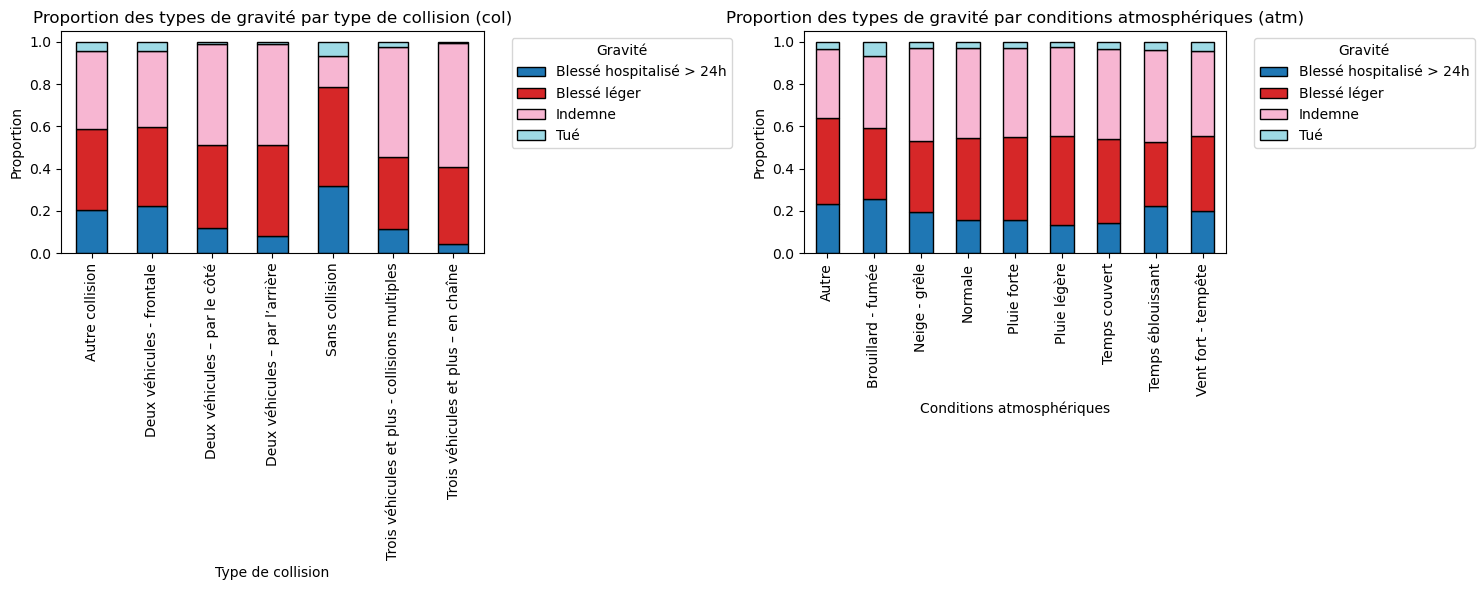

In [118]:

# Remplacement des valeurs avec les labels
df_caract['col'] = df_caract['col'].map(col_labels)
df_caract['atm'] = df_caract['atm'].map(atm_labels)

# Comptage des occurrences par type de gravité et collision (col)
gravite_proportions_col = (
    df_caract.merge(df_usagers, on='Num_Acc')
    .groupby(['col', 'grav'])
    .size()
    .unstack(fill_value=0)
)

# Calcul des proportions de gravité par type de collision
gravite_proportions_col = gravite_proportions_col.div(gravite_proportions_col.sum(axis=1), axis=0)

# Comptage des occurrences par type de gravité et conditions atmosphériques (atm)
gravite_proportions_atm = (
    df_caract.merge(df_usagers, on='Num_Acc')
    .groupby(['atm', 'grav'])
    .size()
    .unstack(fill_value=0)
)

# Calcul des proportions de gravité par conditions atmosphériques
gravite_proportions_atm = gravite_proportions_atm.div(gravite_proportions_atm.sum(axis=1), axis=0)

# Création des graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=False)

# Graphique 1 : Proportion des types de gravité par collision
gravite_proportions_col.plot(kind='bar', stacked=True, ax=axes[0], colormap='tab20', edgecolor='black')
axes[0].set_title("Proportion des types de gravité par type de collision (col)")
axes[0].set_xlabel("Type de collision")
axes[0].set_ylabel("Proportion")
axes[0].tick_params(axis='x')
axes[0].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')

# Graphique 2 : Proportion des types de gravité par conditions atmosphériques
gravite_proportions_atm.plot(kind='bar', stacked=True, ax=axes[1], colormap='tab20', edgecolor='black')
axes[1].set_title("Proportion des types de gravité par conditions atmosphériques (atm)")
axes[1].set_xlabel("Conditions atmosphériques")
axes[1].set_ylabel("Proportion")
axes[1].tick_params(axis='x')
axes[1].legend(title="Gravité", bbox_to_anchor=(1.05, 1), loc='upper left')

# Ajustement de la mise en page
plt.tight_layout()
plt.show()


Répartition par type de collision (col) : Les collisions frontales et latérales présentent une proportion plus élevée de blessés graves et de décès (catégorie "Tué") par rapport aux autres types de collision. Les collisions arrière et multiples sont dominées par des blessures légères et des indemnes. Cela reflète l'impact plus direct et souvent plus intense des collisions frontales et latérales, tandis que les autres types tendent à répartir l'énergie de l'impact de manière plus diffuse.

Répartition par conditions atmosphériques (atm) : Les accidents survenant sous des conditions défavorables comme la neige, la grêle ou le brouillard affichent une proportion notable de gravité sévère, avec plus de blessés graves et de décès. À l'inverse, les accidents par temps clair, bien que plus fréquents, sont associés à une plus forte proportion de blessés légers et d'indemnes. Ces résultats soulignent l'importance des conditions météorologiques dans la gravité des accidents et la nécessité d'adopter une conduite prudente par mauvais temps.

### 2)- Association à la gravité de l'accident: le coéfficient V de Cramer

In [136]:
# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))
    
#Fonction pour la matrice de V de Cramer
def matrice_v_cramer(data,colonnes):
    #Créer un DataFrame vide pour la matrice V de Cramer
    cramers_v_matrix = pd.DataFrame(index=colonnes, columns=colonnes)

    # Calculer les V de Cramer pour chaque paire de colonnes
    for col1 in colonnes:
        for col2 in colonnes:
            cramers_v_matrix.loc[col1, col2] = cramers_v(data[col1], data[col2])

    # Convertir la matrice en valeurs numériques
    cramers_v_matrix = cramers_v_matrix.astype(float)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', cbar=True)
    plt.title("Matrice des V de Cramer")
    plt.show()

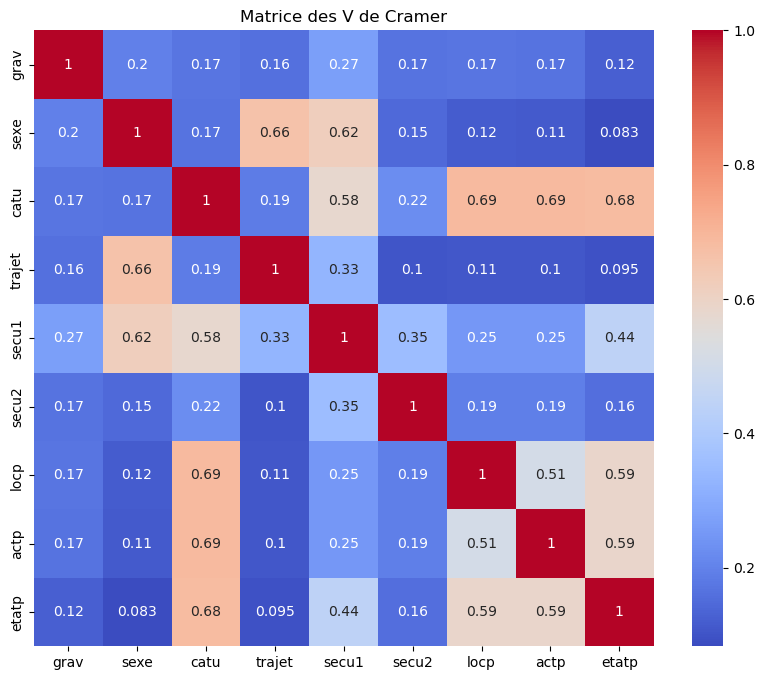

In [ ]:
colonnes_a_inclure1 = ["grav","sexe", "catu", "trajet", "secu1", "secu2", "locp", "actp","etatp"]
matrice_v_cramer(df_merge,colonnes_a_inclure1)

En examinant les relations entre les variables dans cette matrice des V de Cramer, plusieurs dépendances intéressantes apparaissent :
sexe et trajet ont une corrélation notable avec un coefficient de 0,66, indiquant une forte relation entre le genre et le type de trajet. Cela pourrait refléter des différences dans les habitudes ou les comportements de déplacement entre hommes et femmes.
catu et secu1 affichent une relation modérée avec un V de Cramer de 0,58, suggérant que la catégorie d'usager influence le dispositif de sécurité1.
Une forte dépendance est également observée entre catu et locp (0,69) et entre catu et actp (0,69), ce qui indique que la catégorie d'usager est fortement liée à la localisation précise de l'accident ainsi qu'à l'action du piéton.
locp et actp et locp et etap présentent des relations modérées à 0,51 et 0,59, respectivement, révélant une connexion entre la localisation des accidents, l'action du piéton, et les état du piéton.
De plus, actp et etap ont également une relation notable avec un V de Cramer de 0,59, ce qui montre que l'action du piéton est intimement liée à les état du piéton.
En revanche, certaines variables comme trajet et locp (0,11) ou sexe et locp (0,12) montrent des corrélations très faibles, indiquant des relations peu significatives entre ces paires de variables.
Globalement, les relations les plus fortes sont centrées autour de catu, locp, actp, et etap

En se concentrant sur les relations avec la variable cible "grav" (gravité des accidents), voici les observations principales :
secu1 (Equipement de sécurité1) présente une dépendance modérée avec "grav" avec un V de Cramer de 0,28, ce qui suggère une certaine influence sur la gravité des accidents.
secu2 (Dispositif de sécurité2) a une corrélation plus faible avec "grav" à 0,24, montrant une influence moindre par rapport à "secu1".
catu (catégorie d'usager) affiche une valeur de 0,17, indiquant une faible dépendance mais non négligeable.
trajet (type de trajet) et locp (localisation piéton) ont des V de Cramer relativement faibles, à 0,14 et 0,2 respectivement, montrant qu'ils influencent faiblement "grav".
sexe (sexe) et actp (action du piéton) ont des coefficients très faibles, à 0,13 et 0,19 respectivement, indiquant qu'ils n'ont qu'une influence mineure.
Enfin, etap (état du piéton) est la variable la moins corrélée avec "grav", avec un V de Cramer de 0,12.

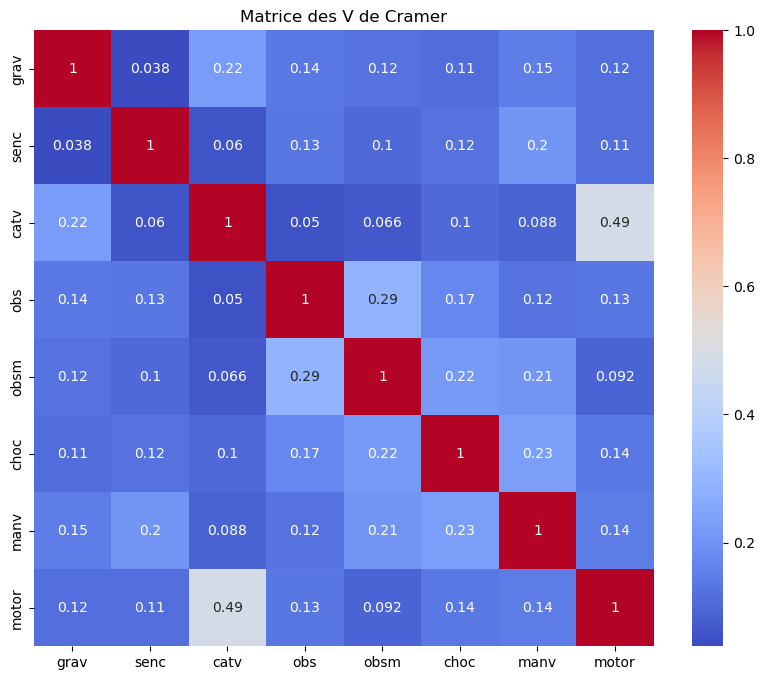

In [ ]:
colonnes_a_inclure2 = ["grav","senc", "catv", "obs", "obsm", "choc", "manv", "motor"]
matrice_v_cramer(df_merge,colonnes_a_inclure2) 

Relations avec la variable cible "grav" :
catv (catégorie du véhicule) montre une corrélation modérée avec grav avec un coefficient de 0,26, indiquant une influence notable de ce facteur sur la gravité des accidents.
obs (obstacle) et manv (manœuvre) présentent des relations faibles mais existantes avec grav, avec des coefficients respectifs de 0,15 et 0,16.
Les autres variables, comme senc (sens de circulation) (0,021), obsm (obstacle mobile) (0,14), choc (type de choc) (0,12), et motor (motorisation) (0,12), montrent des corrélations très faibles avec grav, suggérant qu’elles ont un impact limité sur la gravité.

Relations entre les variables :
catv et motor affichent une corrélation forte (0,52), indiquant que la catégorie du véhicule est étroitement liée à son type de motorisation. Cela reflète logiquement une relation technique ou structurelle entre ces deux caractéristiques.
obs et obsm montrent une relation modérée avec un coefficient de 0,25, suggérant que la présence d’un obstacle est souvent associée à un obstacle mobile.
manv et choc présentent également une corrélation modérée à 0,21, indiquant que la manœuvre effectuée au moment de l’accident est liée au point de choc initial.
Les autres relations entre les variables, comme senc et obs (0,13) ou obsm et choc (0,13), restent faibles, suggérant une interdépendance moins significative.

#### Test de significativité des V de Cramer

In [ ]:
# Fonction pour calculer le V de Cramer et tester la significativité
def verifier_cramers_v_significatif(data, target, variables, alpha=0.05):
    resultats = {}
    for var in variables:
        # Calcul de la matrice de contingence
        confusion_matrix = pd.crosstab(data[target], data[var])
        
        # Test du Chi-carré
        chi2, p, _, _ = chi2_contingency(confusion_matrix)
        
        # Calcul du V de Cramer
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        cramers_v = np.sqrt(phi2 / min(k - 1, r - 1))
        
        # Vérification de la significativité
        significatif = p < alpha
        resultats[var] = {
            "V de Cramer": cramers_v,
            "Significatif": significatif,
            "p-valeur": p
        }
    return resultats

variables_a_verifier = ["catv", "catu", "secu1", "secu2", "obsm", "obs", "manv"]
resultats = verifier_cramers_v_significatif(df_merge, "grav", variables_a_verifier)

for var, stats in resultats.items():
    print(f"Variable: {var}")
    print(f"  V de Cramer: {stats['V de Cramer']:.3f}")
    print(f"  Significatif: {'Oui' if stats['Significatif'] else 'Non'}")
    print(f"  p-valeur: {stats['p-valeur']:.3e}")

Variable: catv
  V de Cramer: 0.225
  Significatif: Oui
  p-valeur: 0.000e+00
Variable: catu
  V de Cramer: 0.170
  Significatif: Oui
  p-valeur: 0.000e+00
Variable: secu1
  V de Cramer: 0.267
  Significatif: Oui
  p-valeur: 0.000e+00
Variable: secu2
  V de Cramer: 0.166
  Significatif: Oui
  p-valeur: 0.000e+00
Variable: obsm
  V de Cramer: 0.124
  Significatif: Oui
  p-valeur: 0.000e+00
Variable: obs
  V de Cramer: 0.137
  Significatif: Oui
  p-valeur: 0.000e+00
Variable: manv
  V de Cramer: 0.149
  Significatif: Oui
  p-valeur: 0.000e+00


Ces V de Cramer des variables sont tous significatifs.

## **III- Modélisation**

De l'analyse descriptive, les variables qui semblent avoir plus d'influence sur la gravité de l'accident sont: la catégorie du véhicule, les équiêments de sécurité 1 et 2, l'obstacle mobile heurté, la catégorie d'usager, l'agglomération, la catégorie de la route, le type de collision, la situation de l'accident, l'obstacle fixe heurté et la manoeuvre utilisé.
On restreint la base de données à ces variables.

In [140]:
df_model=df_merge.drop(['id_usager', 'id_vehicule', 'num_veh', 'sexe', 'an_nais', 'trajet', 'secu3', 'locp','actp', 'etatp', 'senc', 
       'choc', 'motor', 'occutc', 'voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof','pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 
       'infra','vma', 'jour', 'mois', 'an', 'hrmn', 'lum', 'dep', 'com', 'int', 'atm', 'adr', 'lat', 'long'], axis=1)

 Etant donné que dans un accident, il peut y avoir plusieurs niveaux de gravité (car celui-ci depend de chaque individu impliqué dans l'accident), nous allons définir la gravité de l'accident comme étant le niveau de gravité le plus haut des dommages subit par les personnes impliquées dans l'accident. 

Néamoins étant donné que cette procédure va engendré une perte d'information à l'échelle individuelle, nous allons créé deux bases de modélisation. Nous ferons donc une modélisation à l'échelle individuelle, pour prédire la gravité des dommages subit à l'échelle individuelle, puis une modélisation pour prédire la gravité de l'accident.


###  **1)- A l'échelle individuelle**

Dans cette partie, il s'agira de se servir des variables qui donnent les caractéristiques de chaque individu impliquées dans les accidents de voir qu'elles sont celles qui influencent au mieux le niveau de gravité des dommages subit par un individu.

In [141]:
df_model1=df_model.drop(["Num_Acc","manv","catv","obs","obsm","agg","situ","catr","col"], axis=1)

Par la suite, nous définissons une fonction qui fera a la fois du preprocessing sur la base et de la sélection de variables. Plus en détails, cette fonction fais ceci:
- remplacer les valeurs non renseigner par des valeurs manquantes (np.nan);
- supprimer les lignes du dataframe où la gravité de l'accident n'est pas renseigner;
- Imputation des valeurs manquantes par le mode (car il s'agit de variables catégorielles);
- utilisation de l'encodage onehot;
- Entrainement du modèle Lasso sur une série de alpha afin d'en choisir le meilleur
- Entrainement du modèle Lasso avec le meilleur alpha, et en sortie on a le dataframe qui contient uniqement les variables sélectionnées par le modèle.

La regression Lasso est une technique de régularisation qui consiste à appliquer une pénalité pour éviter le surapprentissage et améliorer la précision des modèles statistiques. Aussi, l'encodage onehot est une méthode d'encodage pour les variables catégorielles nominales, qui va creer de nouvelles variables indicatrices et vont faciliter les interprétations des résultats du modèle. La sélection de variables ici consiste donc en réalité en la sélection de catégories qui prédisent aux mieux la gravité.




In [142]:
def selection_var(df_model1):
    for column in df_model1.columns:
        df_model1[column] = df_model1[column].replace(-1, np.nan)
    df_model1 = df_model1.dropna(subset=['grav'])
    lasso_x=df_model1.drop(["grav"],axis=1)
    lasso_y=df_model1["grav"]
    categorical_pipeline = Pipeline(
        steps=[
            ("impute", SimpleImputer(strategy="most_frequent")),
            ("one-hot", OneHotEncoder(drop='first', handle_unknown="ignore", sparse_output=False)),
        ]
    )
    base1=categorical_pipeline.fit_transform(lasso_x)
    data1=pd.DataFrame(data=base1, columns=categorical_pipeline.get_feature_names_out())
    my_alphas = np.array([0.001, 0.01, 0.02, 0.025])
    cv = LassoCV(alphas=my_alphas, fit_intercept=False, random_state=0, cv=3).fit(
        data1, lasso_y)
    model = Lasso(fit_intercept=False, alpha=lcv.alpha_)
    lasso_optimal1=model.fit(data1, lasso_y1)
    data_model1=data1[data1.columns[np.abs(lasso_optimal1.coef_)>0]]
    return data_model1, lasso_y

Nous appliquons la fonction précedemment définie à la base df_model1:

In [145]:
data_model1, lasso_y=selection_var(df_model1)



KeyboardInterrupt: 

La base finale étant ainsi constituée, nous allons entrainer le modèle de régression logistique. Avant cela, il faut diviser la base en un échantillon d'apprentissage et un échantillon de test.

In [72]:
x_train,x_test,y_train,y_test = train_test_split(data_model1,lasso_y, test_size=0.2, random_state=42)

NameError: name 'data_model1' is not defined

Par la suite, nous entrainons plusieurs modèle de régression logistique en faisant varier les hyperparamètres grâce à la gridsearchcv, et nous retenons le modèle avec le meilleur score. Etant donné que la base de données est déséquilibrée, nous rajoutons l'option <<class_weight="balanced">>.Cette option utilise les valeurs de y pour ajuster automatiquement les poids inversement proportionnels à la fréquence des classes dans les données d'entrée comme n_samples / (n_classes * np.bincount(y)).

In [73]:
params={'penalty':["l2",None], 'solver':["newton-cg"]}
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(LogisticRegression(multi_class="multinomial",class_weight="balanced"), params, cv=cv)
grid.fit(x_train, y_train)
print("best params:",grid.best_params_)
print("best score:",grid.best_score_)

NameError: name 'x_train' is not defined

In [ ]:
model=grid.best_estimator_
acc_train = accuracy_score(y_train, model.predict(x_train))
acc_test = accuracy_score(y_test, model.predict(x_test))
print(f"le modèle à un score de {round(acc_train, 2)} sur les données d'entrainnement et {round(acc_test, 2)} sur les données de test.")

Nous allons visualiser les odds_ratio qui donnent l'importance des variables dans la prédiction, en utilisant le coéfficients des variables dans la fonction de  décision.

L'odds ratio est une mesure statistique qui compare les cotes d'un évènement entre deux groupe différents.

In [ ]:
importances = model.coef_[0]
odds_ratios = pd.Series(np.exp(importances), index=data_model1.columns).sort_values() #coefficient des variables dans le modèle
fig1 = px.bar(x=odds_ratios.tail(10),y=odds_ratios.tail(10).index, orientation="h",title="Odds Ratio-reference 1")
fig1.update_layout(xaxis_title="exp(coef)", yaxis_title="Variables")

In [ ]:
importances = model.coef_[1]
odds_ratios = pd.Series(np.exp(importances), index=data_model1.columns).sort_values() #coefficient des variables dans le modèle
fig1 = px.bar(x=odds_ratios.head(10),y=odds_ratios.head(10).index, orientation="h",title="Odds Ratio-reference 1")
fig1.update_layout(xaxis_title="exp(coef)", yaxis_title="Variables")

In [ ]:
importances = model.coef_[2]
odds_ratios = pd.Series(np.exp(importances), index=data_model1.columns).sort_values() #coefficient des variables dans le modèle
fig1 = px.bar(x=odds_ratios.head(10),y=odds_ratios.head(10).index, orientation="h",title="Odds Ratio-reference 1")
fig1.update_layout(xaxis_title="exp(coef)", yaxis_title="Variables")

In [ ]:
importances = model.coef_[3]
odds_ratios = pd.Series(np.exp(importances), index=data_model1.columns).sort_values() #coefficient des variables dans le modèle
fig1 = px.bar(x=odds_ratios.tail(10),y=odds_ratios.tail(10).index, orientation="h",title="Odds Ratio-reference 1")
fig1.update_layout(xaxis_title="exp(coef)", yaxis_title="Variables")

Des graphiques précédents, il en ressort que:
- les usagers qui ont un dispositif pour enfant ou une ceinture de sécurité lors de l'accident ont plus de 6 fois plus de chance d'être indemne par rapport à ceux qui n'ont pas d'équipement de sécurité.
- Ceux qui ont une premier ou un deuxième équipement de sécurité autre (non précisé) ont plus 50% de chance d'être tué lors d'un accident par rapport à ceux qui n'ont pas d'équipement.
- les usagers qui porte un casque ont environ 0,5 fois moins de chance d'être tué par rapport à ceux qui n'ont pas d'équipement de sécurité
- les piétons ont environ 35% de plus de chance d'être bléssé hospitalisé après un accident de la route par rapport aux conducteurs
- un usager assis au fond du véhicule (pour les véhicules à 4 roues ou plus) ont 20% de chance en moins d'être bléssé hospitalisé par rapport à un individu assis devant.
- un usager avec un casque lors de l'accident à 2 fois plus de chance d'être blesser leger lors d'un accident que celui qui n'a pas d'équipement.
- un usager avec comme deuxième équipement de sécurité un Airbag lors de l'accident, a 1.5 fois plus de chance d'être bléssé leger par rapport à celui qui n'a pas d'équipement de sécurité

### **2)-A l'échelle d'un accident**

Nous commencons par définir le niveau de gravité le plus élevé pour chaque accident.

In [74]:
import numpy as np
id_acc=df_model["Num_Acc"].unique()
index_true=[]
for i in id_acc:
    df_id=df_model[df_model["Num_Acc"]==i]
    n_grav=np.max(df_id["grav"])
    index=df_model[(df_model["Num_Acc"]==i) & (df_model["grav"]==n_grav)].index[0]
    index_true.append(index)
        
df_model.drop(["Num_Acc"], axis=1, inplace=True)

In [ ]:
# Niveau de gravité de l'accident présente dans la nouvelle base
df_model=df_model.loc[index_true]
df_model["grav"].value_counts()

Dans les accidents enregistrés, aucun n'a laisser toutes les personnes impliquées indemnes.

On recode la variable "gravité" par: 
- 2: niveau de gravité **grave** (2)
- 3: niveau de gravité **moyen** (1)
- 4: niveau de gravité **faible** (0)

In [ ]:
df_model2["grav"]=df_model2["grav"].replace([3,4], value=[1,0])

# distribution de la gravité
df_model2["grav"].value_counts()/df_model2.shape[0]*100

Par la suite, étant donné que certaines variables ont trop de catégories (par exemple la variable catégorie du véhicule qui a 50 catégories), nous allons aggrégé certaines catégories afin de réduire le nombre de catégories pour ces variables. Dans la nouvelle définition, on a:
- Catégorie de véhicules:
    * 1: véhicules à deux roues
    * 2: quadricycle
    * 3: engin lourd
    * 4: véhicule léger
    * 5: véhicule utilitaire
    * 7: transport en commun
    * 8: 3RM
    * 9: EDP
- Manoeuvre:
    * 1: Sans changement de direction
    * 11: changeant de file
    * 13: déporté
    * 15: tournant
    * 17: dépassant
    * 19: divers
- Obstacle fixe heurté:
    * 3: glissière
    * 12: Bordure de trottoir et autres éléments sur le trottoir
    * 7: Elements de sécurité routière
    * 6: construction
    * 14: bordure de chaussée et autres sur la chaussée

In [ ]:
df_model["manv"] = df_model["manv"].replace(2,value=1)
df_model["manv"] = df_model["manv"].replace(12,value=11)
df_model["manv"] = df_model["manv"].replace(14,value=13)
df_model["manv"] = df_model["manv"].replace(16,value=15)
df_model["manv"] = df_model["manv"].replace(18,value=17)
df_model["manv"] = df_model["manv"].replace([20,21,22,23,24,25,26],value=19)

df_model["obs"] = df_model["obs"].replace([4,5],value=3)
df_model["obs"] = df_model["obs"].replace(15,value=12)
df_model["obs"] = df_model["obs"].replace([8,11],value=7)
df_model["obs"] = df_model["obs"].replace(10,value=6)
df_model["obs"] = df_model["obs"].replace(16,value=14)

df_model["catv"] = df_model["catv"].replace([4,30,32,2,5,31,33,34],value=1)
df_model["catv"] = df_model["catv"].replace([36,35,3],value=2)
df_model["catv"] = df_model["catv"].replace([20,21,13,14,15],value=3)
df_model["catv"] = df_model["catv"].replace([7,8,9],value=4)
df_model["catv"] = df_model["catv"].replace([10,11,12],value=5)
df_model["catv"] = df_model["catv"].replace([16,17],value=7)
df_model["catv"] = df_model["catv"].replace([18,37,39,19,40,38],value=8)
df_model["catv"] = df_model["catv"].replace([41,42,43],value=9)
df_model["catv"] = df_model["catv"].replace([50,60],value=10)

Entrainons à présent le modèle de régression logistique avec les données.

In [ ]:
datamodel_2, lasso_y=selection_var(df_model)
x_train,x_test,y_train,y_test = train_test_split(datamodel_2, lasso_y , test_size=0.2, random_state=42)
params={'penalty':["l2",None], 'solver':["newton-cg"]}
cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid = GridSearchCV(LogisticRegression(multi_class="multinomial",class_weight="balanced"), params, cv=cv)
grid.fit(x_train, y_train)
print("best params:",grid.best_params_)
print("best score:",grid.best_score_)

In [ ]:
model=grid.best_estimator_
acc_train = accuracy_score(y_train, model.predict(x_train))
acc_test = accuracy_score(y_test, model.predict(x_test))
print(f"le modèle à un score de {round(acc_train, 2)} sur les données d'entrainnement et {round(acc_test, 2)} sur les données de test.")

In [ ]:
#confusion matrix
from sklearn import metrics
predictions = model.predict(x_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_test)


Le modèle prédit correctement qu'un accident est de gravité faible dans 66% des cas, qu'il est de gravité moyen dans 29% des cas et qu'il est de gravité élevée dans 59% des cas.

Visualisons ensuite l'importance des variables dans le prédiction.

In [ ]:
importances1 = model.coef_[0]
odds_ratios1 = pd.Series(np.exp(importances1), index=datamodel_2.columns).sort_values() #coefficient des variables dans le modèle
fig1 = px.bar(x=odds_ratios1.tail(10),y=odds_ratios1.tail(10).index, orientation="h",title="Odds Ratio-reference 1")
fig1.update_layout(xaxis_title="exp(coef)", yaxis_title="Variables")

In [ ]:
importances2 = model.coef_[1]
odds_ratios2 = pd.Series(np.exp(importances2), index=datamodel_2.columns).sort_values() #coefficient des variables dans le modèle
fig2 = px.bar(x=odds_ratios2.tail(10),y=odds_ratios2.tail(10).index, orientation="h",title="Odds Ratio-reference 2")
fig2.update_layout(xaxis_title="exp(coef)", yaxis_title="Variables")

In [ ]:
importances2 = model.coef_[2]
odds_ratios2 = pd.Series(np.exp(importances2), index=datamodel_2.columns).sort_values() #coefficient des variables dans le modèle
fig2 = px.bar(x=odds_ratios2.tail(10),y=odds_ratios2.tail(10).index, orientation="h",title="Odds Ratio-reference 2")
fig2.update_layout(xaxis_title="exp(coef)", yaxis_title="Variables")

Des graphiques ci-dessus, il en ressort que: 
- un accident en agglomération à 2.2 fois plus de chance d'être de niveau de gravité faible que celui hors agglomération.
- un accident impliquant un véhicule entre 2 files à 2 fois plus de chance d'être de niveau faible par rapport à une manoeuvre inconnue.
- un accident impliquant une collision de trois vehicules et plus en chaine à presque 2 fois plus de chance d'être d'avoir une gravité faible qu'un accident avec une collision de deux véhicules en frontale.
- un accident sur un parc de stationnement ouvert à la circulation publique augmente de 55% la chance qu'il soit de niveau de gravité moyen par rapport à un accident sur l'autoroute.
- un accident sur une route départementale augmente la probabilité de 30% que l'accident soit de gravité moyenne par rapport à un accident sur l'autoroute
- un accident impliquant un véhicule de transport en commun ou un engin lourd à presque 3 fois plus de chance d'être de gravité élevé (au moins une personne tuée) que les accidents impliquants des véhicules de catégorie indéterminable.


## **Conclusion générale**